# 🚲 DSF 2023 - Predicting the number of cyclists in the town of St. Gallen 🚲

### Group 05:
Tonio Isenschmid: 22-607-758<br>
Luc Brem: 22-610-398<br>
Nina Maeder: 22-611-966<br>

#### Datasets:

1. velozahlungen-stadt-stgallen-tagesaggregation[at]stadt-stgallen.csv (www.daten.sg.ch)
2. wetterdaten-klimamessnetz-kanton-stgallen-tageswerte.csv (www.daten.sg.ch)
3. Dates for the main events of the city of St. Gallen (www.stadt.sg.ch)
4. Dates for holidays of the city of St. Gallen (www.feiertagskalender.ch)

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Third-Party Libraries

# Data Preprocessing and Analysis
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# Model Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Cross-Validation and Model Selection utilities 
from sklearn.model_selection import cross_validate, cross_val_score, KFold, TimeSeriesSplit


The raw datasets are first explored individually to understand their structure and contents. Subsequently, they are merged to generate a unified dataset for comprehensive analysis and modeling.

In [2]:
# Reading csv file containing bike counts for St. Gallen at different locations
velo = pd.read_csv("Project/velozahlungen-stadt-stgallen-tagesaggregation@stadt-stgallen.csv", sep = ";")

In [3]:
# Extracting bike count data for a particular date to analyze location-based counting variations
velo_test = velo[velo["Datum"] == "2020-07-30"] 
velo_test

,Datum,Bezeichnung,Standort,Arbeitstag,Wochentag,Tag Nr,Kennzahl,Anzahl Velos
4819,2020-07-30,Oberstrasse 149,"47.414179, 9.356962",Werktage,Donnerstag,4,"Tagesverkehr,Werktagsverkehr",1433
4820,2020-07-30,Sitterviadukt A1 / Gaiserwaldweg,"47.42203, 9.34464",Werktage,Donnerstag,4,"Tagesverkehr,Werktagsverkehr",352
4821,2020-07-30,St.Jakob-Strasse 84 / Olma,"47.4322, 9.382405",Werktage,Donnerstag,4,"Tagesverkehr,Werktagsverkehr",785
12017,2020-07-30,Rorschacher Strasse 61 / Singenberg,"47.427438, 9.384005",Werktage,Donnerstag,4,"Tagesverkehr,Werktagsverkehr",602
19913,2020-07-30,Burgstrasse 12,"47.419783, 9.364792",Werktage,Donnerstag,4,"Tagesverkehr,Werktagsverkehr",452
19914,2020-07-30,Lindenstrasse 134,"47.436818, 9.4017",Werktage,Donnerstag,4,"Tagesverkehr,Werktagsverkehr",523
28045,2020-07-30,Lindenstrasse 81,"47.433406, 9.394689",Werktage,Donnerstag,4,"Tagesverkehr,Werktagsverkehr",398
28046,2020-07-30,Linsebühlstrasse / Singenbergstrasse,"47.426377, 9.386272",Werktage,Donnerstag,4,"Tagesverkehr,Werktagsverkehr",422
28047,2020-07-30,Rosenbergstrasse Veloweg,"47.421245, 9.359067",Werktage,Donnerstag,4,"Tagesverkehr,Werktagsverkehr",633
28048,2020-07-30,SBB Sitterviadukt Gübsenweg Ost,"47.40377, 9.324",Werktage,Donnerstag,4,"Tagesverkehr,Werktagsverkehr",969


In [4]:
# Sort the bike data by date and drop unnessecary columns
velo_sorted = velo.sort_values(by="Datum")
velo_sorted = velo_sorted.reset_index(drop = True)
velo_sorted.drop(columns= ["Standort", "Tag Nr", "Kennzahl", "Arbeitstag"], inplace = True)
velo_sorted

,Datum,Bezeichnung,Wochentag,Anzahl Velos
0,2011-07-08,Museumstrasse,Freitag,480
1,2011-07-09,Museumstrasse,Samstag,344
2,2011-07-10,Museumstrasse,Sonntag,115
3,2011-07-11,Museumstrasse,Montag,476
4,2011-07-12,Museumstrasse,Dienstag,537
...,...,...,...,...
38618,2021-12-31,St.Jakob-Strasse 84 / Olma,Freitag,316
38619,2021-12-31,Teufener Strasse 55,Freitag,95
38620,2021-12-31,Museumstrasse,Freitag,172
38621,2021-12-31,St.Georgen / Mühlegg,Freitag,196


In [5]:
# Reading csv file containing weather data for St. Gallen 
weather = pd.read_csv("Project/wetterdaten-klimamessnetz-kanton-stgallen-tageswerte.csv", sep = ";")

In [6]:
# Sort the weather data by date
weather_sorted = weather.sort_values(by="Datum")

# Only keep the relevant columns out of the original weather dataset
weather = weather_sorted[["Datum", "Gesamtschneehöhe; Morgenmessung von 6 UTC", "Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag", 
                          "Sonnenscheindauer; Tagessumme", "Lufttemperatur 2 m über Boden; Tagesmittel", "Relative Luftfeuchtigkeit 2 m über Boden; Tagesmittel"]]
weather = weather.reset_index(drop = True)

# Trimming weather data to correspond to the dates in the bike data
weather = weather[188: 4018] 
weather = weather.reset_index(drop = True) 

In [7]:
# Merging bike data and weather data with an outer join
df = pd.merge(velo_sorted, weather, how="outer")

# Creating dummy variables for "Wochentag" (day of the week)
dummies_wochentag = pd.get_dummies(df["Wochentag"])
df = pd.concat([df, dummies_wochentag], axis=1)

# Reordering columns for each day of the week
df.insert(10, "Montag", df.pop("Montag"))
df.insert(11, "Dienstag", df.pop("Dienstag"))
df.insert(12, "Mittwoch", df.pop("Mittwoch"))
df.insert(13, "Donnerstag", df.pop("Donnerstag"))
df.insert(13, "Freitag", df.pop("Freitag"))
df.drop(columns=["Wochentag"], inplace=True)
df


,Datum,Bezeichnung,Anzahl Velos,Gesamtschneehöhe; Morgenmessung von 6 UTC,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,Sonnenscheindauer; Tagessumme,Lufttemperatur 2 m über Boden; Tagesmittel,Relative Luftfeuchtigkeit 2 m über Boden; Tagesmittel,Montag,Dienstag,Mittwoch,Donnerstag,Freitag,Samstag,Sonntag
0,2011-07-08,Museumstrasse,480,0.0,1.2,387.0,15.8,81.3,False,False,False,False,True,False,False
1,2011-07-09,Museumstrasse,344,0.0,10.9,360.0,18.8,74.7,False,False,False,False,False,True,False
2,2011-07-10,Museumstrasse,115,0.0,63.0,358.0,17.8,85.9,False,False,False,False,False,False,True
3,2011-07-11,Museumstrasse,476,0.0,0.0,602.0,18.1,77.8,True,False,False,False,False,False,False
4,2011-07-12,Museumstrasse,537,0.0,8.6,657.0,21.5,68.5,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38618,2021-12-31,St.Jakob-Strasse 84 / Olma,316,0.0,0.0,360.0,10.5,68.4,False,False,False,False,True,False,False
38619,2021-12-31,Teufener Strasse 55,95,0.0,0.0,360.0,10.5,68.4,False,False,False,False,True,False,False
38620,2021-12-31,Museumstrasse,172,0.0,0.0,360.0,10.5,68.4,False,False,False,False,True,False,False
38621,2021-12-31,St.Georgen / Mühlegg,196,0.0,0.0,360.0,10.5,68.4,False,False,False,False,True,False,False


Key event dates in St. Gallen as supplemental features to our bike prediction model are added. 
1. Openair St. Gallen, OASG (usually around the last June weekend of the corresponding year)
2. Longines CSIO, international show jumping competition with horses (around the end of May)
3. St. Gallen Symposium (beginning of May)
4. OLMA, agricultural fair (mid-october)
5. St. Galler City Festival (mid-August)

Additionally, we incorporated official holidays in St. Gallen as another feature column.

In [8]:
# Converting the "Datum" column to datetime format 
df["Datum"] = pd.to_datetime(df["Datum"], format="%Y-%m-%d")

In [9]:
# List of conditions for the OASG dates
conditionsOASG = [
    (2019, 6, [27, 28, 29, 30]),
    (2018, 7, [1]),
    (2018, 6, [28, 29, 30]),
    (2017, 7, [1, 2]),
    (2017, 6, [29, 30]),
    (2016, 6, [1, 2, 3]),
    (2016, 6, [30]),
    (2015, 6, [25, 26, 27, 28]),
    (2014, 6, [26, 27, 28, 29]),
    (2013, 6, [27, 28, 29, 30]),
    (2012, 7, [1]),
    (2012, 6, [28, 29, 30]),
    (2011, 7, [1, 2, 3]),
    (2011, 6, [30])
]

# Initialize a new column "OASG"
df["OASG"] = False

# Loop through the conditions and set "OASG" column to True for those rows, when the event has taken place
for year, month, days in conditionsOASG:
    condition = (df["Datum"].dt.year == year) & (df["Datum"].dt.month == month) & (df["Datum"].dt.day.isin(days))
    df["OASG"] = df["OASG"] | condition


In [10]:
# List of conditions for the CSIO dates
conditionsCSIO = [
    (2021, 6, [3, 4, 5, 6]),
    (2019, 5, [29, 30, 31]),
    (2019, 6, [1]),
    (2018, 6, [1, 2, 3]),
    (2018, 5, [31]),
    (2017, 6, [1, 2, 3, 4]),
    (2016, 6, [2, 3, 4, 5]),
    (2015, 6, [4, 5, 6, 7]),
    (2014, 5, [29, 30, 31]),
    (2014, 6, [1]),
    (2013, 5, [30, 31]),
    (2013, 6, [1, 2]),
    (2012, 5, [31]),
    (2012, 6, [1, 2, 3]),
    (2011, 6, [2, 3, 4, 5])
]

# Initialize a new column "CSIO"
df["CSIO"] = False

# Loop through the conditions and set "CSIO" column to True for those rows, when the event has taken place
for year, month, days in conditionsCSIO:
    condition = (df["Datum"].dt.year == year) & (df["Datum"].dt.month == month) & (df["Datum"].dt.day.isin(days))
    df["CSIO"] = df["CSIO"] | condition


In [11]:
# List of conditions for the St. Gallen Symposium dates
conditionsSYMPOSIUM = [
    (2021, 5, [6, 7]),
    (2019, 5, [8, 9]),
    (2018, 5, [2, 3, 4]),
    (2017, 5, [4, 5]),
    (2016, 5, [11, 12, 13]),
    (2015, 5, [7, 8]),
    (2014, 5, [8, 9]),
    (2013, 5, [2, 3]),
    (2012, 5, [3, 4]),
    (2011, 5, [12, 13])
]
# Initialize a new column "Symposium"
df["Symposium"] = False

# Loop through the conditions and set "Symposium" column to True for those rows, when the event has taken place
for year, month, days in conditionsSYMPOSIUM:
    condition = (df["Datum"].dt.year == year) & (df["Datum"].dt.month == month) & (df["Datum"].dt.day.isin(days))
    df["Symposium"] = df["Symposium"] | condition


In [12]:
# List of conditions for the OLMA dates
conditionsOLMA = [
    (2011, 10, [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]),
    (2012, 10, [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
    (2013, 10, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
    (2014, 10, [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
    (2015, 10, [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]),
    (2016, 10, [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]),
    (2017, 10, [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]),
    (2018, 10, [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
    (2019, 10, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
    (2021, 10, [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
]

# Initialize a new column "OLMA" 
df["OLMA"] = False

# Loop through the conditions and set "OLMA" column to True for those rows, when the event has taken place
for year, month, days in conditionsOLMA:
    condition = (df["Datum"].dt.year == year) & (df["Datum"].dt.month == month) & (df["Datum"].dt.day.isin(days))
    df["OLMA"] = df["OLMA"] | condition


In [13]:
# List of conditions for the St. Gallen City Festival dates
conditionsFEST = [
    (2021, 8, [20, 21]),
    (2019, 8, [16, 17]),
    (2018, 8, [17, 18]),
    (2017, 8, [18, 19]),
    (2016, 8, [19, 20]),
    (2015, 8, [14, 15]),
    (2014, 8, [15, 16]),
    (2013, 8, [16, 17]),
    (2012, 8, [17, 18]),
    (2011, 8, [19, 20])
]

# Initialize a new column "Fest" 
df["Fest"] = False

# Loop through the conditions and set "Fest" column to True for those rows, when the event has taken place
for year, month, days in conditionsFEST:
    condition = (df["Datum"].dt.year == year) & (df["Datum"].dt.month == month) & (df["Datum"].dt.day.isin(days))
    df["Fest"] = df["Fest"] | condition


In [14]:
# Define date ranges for holidays in St. Gallen
holiday_ranges = [
    (pd.to_datetime("2011-01-01"), pd.to_datetime("2011-02-01")),
    (pd.to_datetime("2011-01-29"), pd.to_datetime("2011-02-06")),
    (pd.to_datetime("2011-04-10"), pd.to_datetime("2011-04-25")),
    (pd.to_datetime("2011-06-02"), pd.to_datetime("2011-06-03")),
    (pd.to_datetime("2011-07-10"), pd.to_datetime("2011-08-14")),
    (pd.to_datetime("2011-10-02"), pd.to_datetime("2011-10-23")),
    (pd.to_datetime("2011-12-24"), pd.to_datetime("2011-12-31")),
    (pd.to_datetime("2012-01-01"), pd.to_datetime("2012-02-02")),
    (pd.to_datetime("2012-01-28"), pd.to_datetime("2012-02-05")),
    (pd.to_datetime("2012-04-08"), pd.to_datetime("2012-04-22")),
    (pd.to_datetime("2012-05-17"), pd.to_datetime("2012-05-18")),
    (pd.to_datetime("2012-07-08"), pd.to_datetime("2012-08-12")),
    (pd.to_datetime("2012-09-20"), pd.to_datetime("2012-10-21")),
    (pd.to_datetime("2012-12-22"), pd.to_datetime("2012-12-31")),
    (pd.to_datetime("2013-01-01"), pd.to_datetime("2013-01-06")),
    (pd.to_datetime("2013-01-26"), pd.to_datetime("2013-02-03")),
    (pd.to_datetime("2013-04-06"), pd.to_datetime("2013-04-21")),
    (pd.to_datetime("2013-05-09"), pd.to_datetime("2013-05-12")),
    (pd.to_datetime("2013-07-07"), pd.to_datetime("2013-08-11")),
    (pd.to_datetime("2013-09-29"), pd.to_datetime("2013-10-20")),
    (pd.to_datetime("2013-12-22"), pd.to_datetime("2013-12-31")),
    (pd.to_datetime("2014-01-01"), pd.to_datetime("2014-01-05")),
    (pd.to_datetime("2014-01-25"), pd.to_datetime("2014-02-02")),
    (pd.to_datetime("2014-04-05"), pd.to_datetime("2014-04-21")),
    (pd.to_datetime("2014-05-29"), pd.to_datetime("2014-06-01")),
    (pd.to_datetime("2014-07-05"), pd.to_datetime("2014-08-10")),
    (pd.to_datetime("2014-09-27"), pd.to_datetime("2014-10-19")),
    (pd.to_datetime("2014-12-21"), pd.to_datetime("2014-12-31")),
    (pd.to_datetime("2015-01-01"), pd.to_datetime("2015-01-04")),
    (pd.to_datetime("2015-01-24"), pd.to_datetime("2015-02-01")),
    (pd.to_datetime("2015-04-03"), pd.to_datetime("2015-04-19")),
    (pd.to_datetime("2015-05-14"), pd.to_datetime("2015-05-17")),
    (pd.to_datetime("2015-07-04"), pd.to_datetime("2015-08-09")),
    (pd.to_datetime("2015-09-26"), pd.to_datetime("2015-10-18")),
    (pd.to_datetime("2015-12-19"), pd.to_datetime("2015-12-31")),
    (pd.to_datetime("2016-01-01"), pd.to_datetime("2016-01-03")),
    (pd.to_datetime("2016-01-30"), pd.to_datetime("2016-02-07")),
    (pd.to_datetime("2016-04-09"), pd.to_datetime("2016-04-24")),
    (pd.to_datetime("2016-05-05"), pd.to_datetime("2016-05-08")),
    (pd.to_datetime("2016-07-09"), pd.to_datetime("2016-08-14")),
    (pd.to_datetime("2016-10-01"), pd.to_datetime("2016-10-23")),
    (pd.to_datetime("2016-12-24"), pd.to_datetime("2016-12-31")),
    (pd.to_datetime("2017-01-01"), pd.to_datetime("2017-01-08")),
    (pd.to_datetime("2017-01-28"), pd.to_datetime("2017-02-05")),
    (pd.to_datetime("2017-04-08"), pd.to_datetime("2017-04-23")),
    (pd.to_datetime("2017-05-25"), pd.to_datetime("2017-05-28")),
    (pd.to_datetime("2017-06-05"), pd.to_datetime("2017-06-05")),
    (pd.to_datetime("2017-07-08"), pd.to_datetime("2017-08-13")),
    (pd.to_datetime("2017-09-30"), pd.to_datetime("2017-10-22")),
    (pd.to_datetime("2017-11-01"), pd.to_datetime("2017-11-01")),
    (pd.to_datetime("2017-12-23"), pd.to_datetime("2017-12-31")),
    (pd.to_datetime("2018-01-01"), pd.to_datetime("2018-01-07")),
    (pd.to_datetime("2018-01-27"), pd.to_datetime("2018-02-04")),
    (pd.to_datetime("2018-03-30"), pd.to_datetime("2018-04-02")),
    (pd.to_datetime("2018-04-07"), pd.to_datetime("2018-04-22")),
    (pd.to_datetime("2018-05-10"), pd.to_datetime("2018-05-13")),
    (pd.to_datetime("2018-05-21"), pd.to_datetime("2018-05-21")),
    (pd.to_datetime("2018-07-07"), pd.to_datetime("2018-08-12")),
    (pd.to_datetime("2018-09-29"), pd.to_datetime("2018-10-21")),
    (pd.to_datetime("2018-11-01"), pd.to_datetime("2018-11-01")),
    (pd.to_datetime("2018-12-22"), pd.to_datetime("2018-12-31")),
    (pd.to_datetime("2019-01-01"), pd.to_datetime("2019-01-06")),
    (pd.to_datetime("2019-01-26"), pd.to_datetime("2019-02-03")),
    (pd.to_datetime("2019-04-06"), pd.to_datetime("2019-04-22")),
    (pd.to_datetime("2019-05-30"), pd.to_datetime("2019-06-02")),
    (pd.to_datetime("2019-06-10"), pd.to_datetime("2019-06-10")),
    (pd.to_datetime("2019-07-06"), pd.to_datetime("2019-08-11")),
    (pd.to_datetime("2019-09-28"), pd.to_datetime("2019-10-20")),
    (pd.to_datetime("2019-11-01"), pd.to_datetime("2019-11-01")),
    (pd.to_datetime("2019-12-21"), pd.to_datetime("2019-12-31")),
    (pd.to_datetime("2020-01-01"), pd.to_datetime("2020-01-05")),
    (pd.to_datetime("2020-01-25"), pd.to_datetime("2020-02-02")),
    (pd.to_datetime("2020-04-04"), pd.to_datetime("2020-04-19")),
    (pd.to_datetime("2020-05-21"), pd.to_datetime("2020-05-24")),
    (pd.to_datetime("2020-06-01"), pd.to_datetime("2020-06-01")),
    (pd.to_datetime("2020-07-04"), pd.to_datetime("2020-08-09")),
    (pd.to_datetime("2020-09-26"), pd.to_datetime("2020-10-18")),
    (pd.to_datetime("2020-12-19"), pd.to_datetime("2020-12-31")),
    (pd.to_datetime("2021-01-01"), pd.to_datetime("2021-01-03")),
    (pd.to_datetime("2021-01-30"), pd.to_datetime("2021-02-07")),
    (pd.to_datetime("2021-04-02"), pd.to_datetime("2021-04-05")),
    (pd.to_datetime("2021-04-10"), pd.to_datetime("2021-04-25")),
    (pd.to_datetime("2021-05-13"), pd.to_datetime("2021-05-16")),
    (pd.to_datetime("2021-05-24"), pd.to_datetime("2021-05-24")),
    (pd.to_datetime("2021-07-10"), pd.to_datetime("2021-08-15")),
    (pd.to_datetime("2021-10-02"), pd.to_datetime("2021-10-24")),
    (pd.to_datetime("2021-11-01"), pd.to_datetime("2021-11-01")),
    (pd.to_datetime("2021-12-18"), pd.to_datetime("2021-12-31")),
]

# Function to check if a date is a holiday in St. Gallen
def is_holiday(Datum):
    Datum = pd.to_datetime(Datum)  # Convert Datum to datetime object
    for start, end in holiday_ranges:
        if start <= Datum <= end:
            return True # If the date is a holiday, it returns "True"
    return False

# Create a new column "IsHoliday" based on the "Datum" column
df["IsHoliday"] = df["Datum"].apply(is_holiday)

Further preprocessing of the data
- scaling of date related features
- handling missing values

In [15]:
# Take the month from the "Datum" column and create a new column with the just the month
df["Monat"] = df["Datum"].dt.month
col = df.pop("Monat")
df.insert(3, col.name, col)

# Create cycles of months using sine and cosine functions
df["Monat_sinus"] = np.sin(2 * np.pi * df["Monat"] / 12)
df["Monat_cosinus"] = np.cos(2 * np.pi * df["Monat"] / 12)

# Reordering the new columns towards the front to have all date-related columns first
col = df.pop("Monat_sinus")
df.insert(4, col.name, col)
col = df.pop("Monat_cosinus")
df.insert(5, col.name, col)


# Scaling the "Jahr" (year) column using StandardScaler
scaler = StandardScaler()
df["Jahr"] = df["Datum"].dt.year # store the original values
col = df.pop("Jahr") 
df.insert(2, col.name, col) 
df["Jahr skaliert"] = scaler.fit_transform(df[["Jahr"]]) # Scale the "Jahr" column in a new column "Jahr skaliert"
col = df.pop("Jahr skaliert")
df.insert(3, col.name, col)

# Filling missing values in "Sonnenscheindauer; Tagessumme" column are replaced with the mean value of the respective "Jahr" and "Monat" groups
df["Sonnenscheindauer; Tagessumme"] = df.groupby(["Jahr", "Monat"])["Sonnenscheindauer; Tagessumme"]\
                                        .transform(lambda x: x.fillna(x.mean()))
df[df["Sonnenscheindauer; Tagessumme"].isna()] # check for any remaining NaN values


,Datum,Bezeichnung,Jahr,Jahr skaliert,Anzahl Velos,Monat,Monat_sinus,Monat_cosinus,Gesamtschneehöhe; Morgenmessung von 6 UTC,Niederschlag; Tagessumme 6 UTC - 6 UTC Folgetag,...,Donnerstag,Freitag,Samstag,Sonntag,OASG,CSIO,Symposium,OLMA,Fest,IsHoliday


In [16]:
# A function, "count_zeros", that creates a boolean mask where True stands for zero values. It then sums up all the True values.
def count_zeros(series):
    return (series == 0).sum()

# Grouping the dataframe by "Bezeichnung" and applying the "count_zeros" function to count zeros in for every location 
zero_counts = df.groupby("Bezeichnung")["Anzahl Velos"].apply(count_zeros)

zero_counts


Bezeichnung
Burgstrasse 12                            4
Lindenstrasse 134                        40
Lindenstrasse 81                          0
Linsebühlstrasse / Singenbergstrasse      2
Museumstrasse                            57
Oberstrasse 149                          34
Rorschacher Strasse 61 / Singenberg       1
Rosenbergstrasse Veloweg                 14
SBB Sitterviadukt Gübsenweg Ost          89
Sitterviadukt A1 / Gaiserwaldweg          1
Splügenweg / Olma                         1
St.Georgen / Mühlegg                     20
St.Jakob-Strasse 84 / Olma               40
Teufener Strasse 55                       0
Vadianstrasse 8                         249
Name: Anzahl Velos, dtype: int64

On certain days, there were zero recorded measurements for bikes. However this doesn't reflect actual measurements, but issues with the measuring system.
There aren't single days with 0 measurements, it's always 10,20,30 or more observations after eachother that are 0. 
We tried to impute these "0-count-days" with the mean of the past 7 observations from the same location. However, that approach proved ineffective as there are some consecutive strings of 30 or more zeroes in a row.
Expanding the number of days considered in this mean calculation to 30 or beyond appeared impractical and yielded higher Mean Squared Error (MSE) and Mean Absolute Error (MAE) when we tried it. Since there are only approximately 552/38623 = 1.4% 0s we decided to just drop them.

In [17]:
# Drop rows where "Anzahl Velos" is 0 
df = df[df["Anzahl Velos"] != 0]

In [18]:
# Get the unique locations out of the "Bezeichnung" column
orte = df["Bezeichnung"].unique()  # Get the unique values

# Creating a dictionary to store dataframes for each location
df_dict = {}

for ort in orte:
    df_dict[ort] = df[df["Bezeichnung"] == ort]

In [19]:
# Collect the location names from the dictionary "df_dict" and stores them in a list 
names = []
for i in df_dict:
    names.append(i)

In [56]:
names

('Teufener Strasse 55',
 'Splügenweg / Olma',
 'Sitterviadukt A1 / Gaiserwaldweg',
 'Lindenstrasse 81',
 'Linsebühlstrasse / Singenbergstrasse',
 'Museumstrasse',
 'Lindenstrasse 134',
 'Rosenbergstrasse Veloweg',
 'Burgstrasse 12',
 'St.Jakob-Strasse 84 / Olma',
 'St.Georgen / Mühlegg',
 'Rorschacher Strasse 61 / Singenberg',
 'Oberstrasse 149',
 'SBB Sitterviadukt Gübsenweg Ost',
 'Vadianstrasse 8')

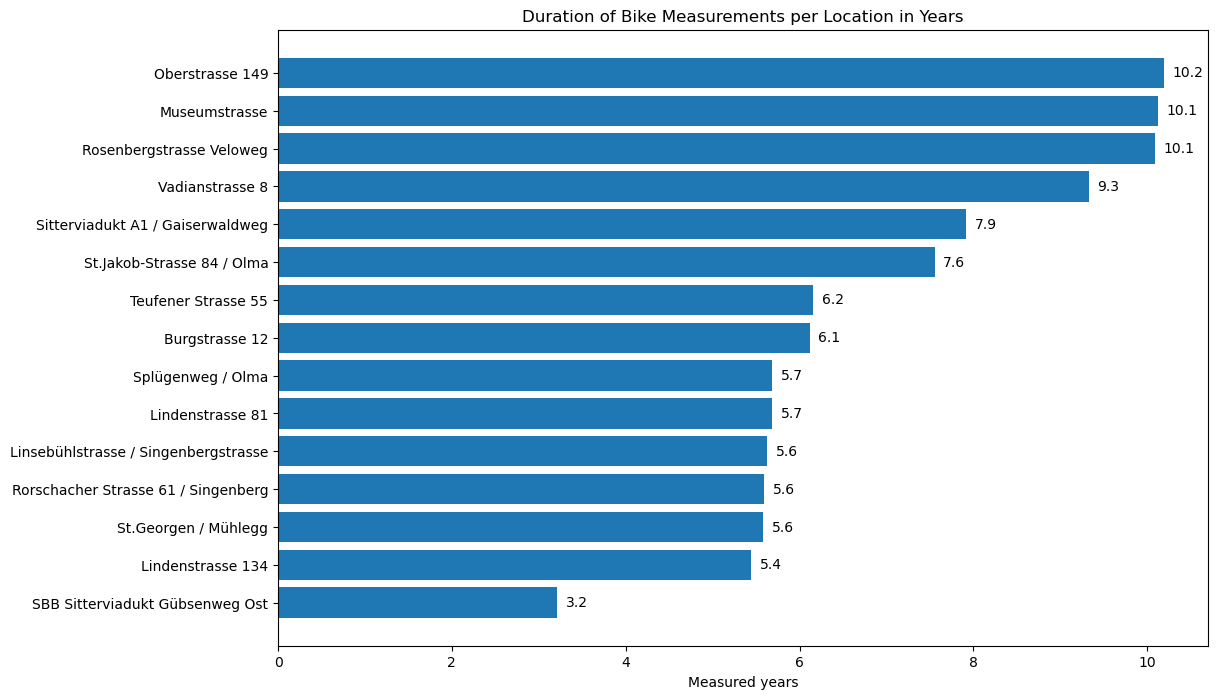

In [58]:
# Calculate the duration of how long in each location of our dictionary the bike counting station was active
lengths = [df_dict[ort].shape[0]/365 for ort in names]

# Sorting the names list according to the lengths
sorted_pairs = sorted(zip(lengths, names))
lengths, names = zip(*sorted_pairs)

# Creating a plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(names, lengths, color = "blue")
bars = ax.barh(names, lengths)

# Setting title labels
ax.set_xlabel("Measured years")
ax.set_title("Duration of Bike Measurements per Location in Years")

# Creating numbers at the end of the bars
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.1  
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{width:.1f}", va="center")
   
plt.show()

Visualise temporal patterns:
- Overall bike counts over time
- Decompose our time series data into trend, seasonality, and residuals

We want to carefully look at our outcome variable "Anzahl Velos"

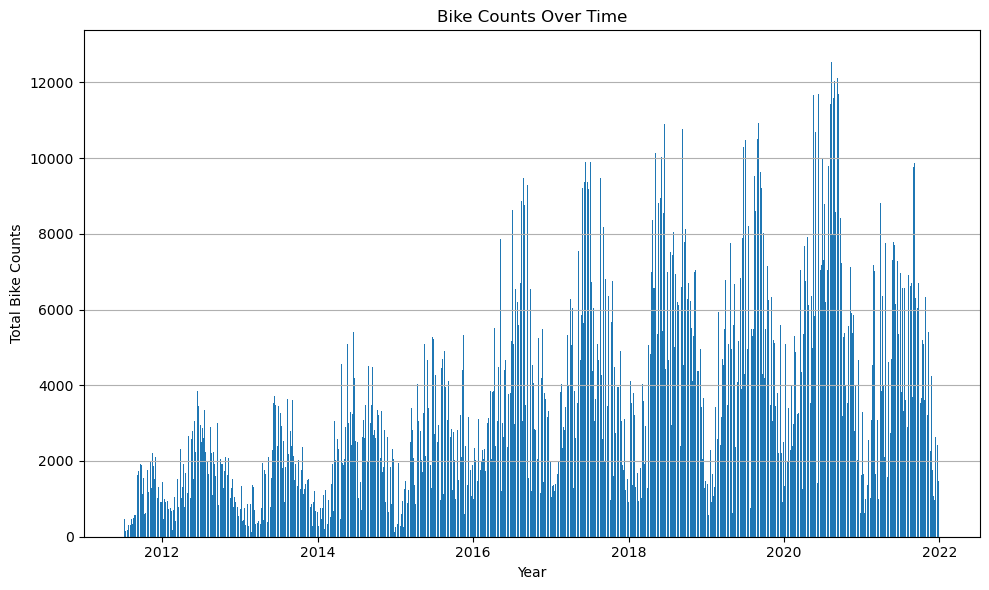

In [22]:
# Creating a plot to visualize bike counts over time

# Grouping by a certain date and taking the sum
sum_per_date = df.groupby("Datum")["Anzahl Velos"].sum()

plt.figure(figsize=(10, 6))
plt.bar(sum_per_date.index, sum_per_date.values)

# Setting title, labels and grid
plt.title("Bike Counts Over Time")
plt.xlabel("Year")
plt.ylabel("Total Bike Counts")
plt.grid(axis="y")

plt.tight_layout()
#plt.savefig("Project/bike counts over time.png", bbox_inches="tight")


plt.show()

The apparent increase in bike counts over time doesn't necessarily imply a rise in cycling popularity. As the following plot demonstrates, the total bike count per day elevates with the increasing number of counting locations over the years.

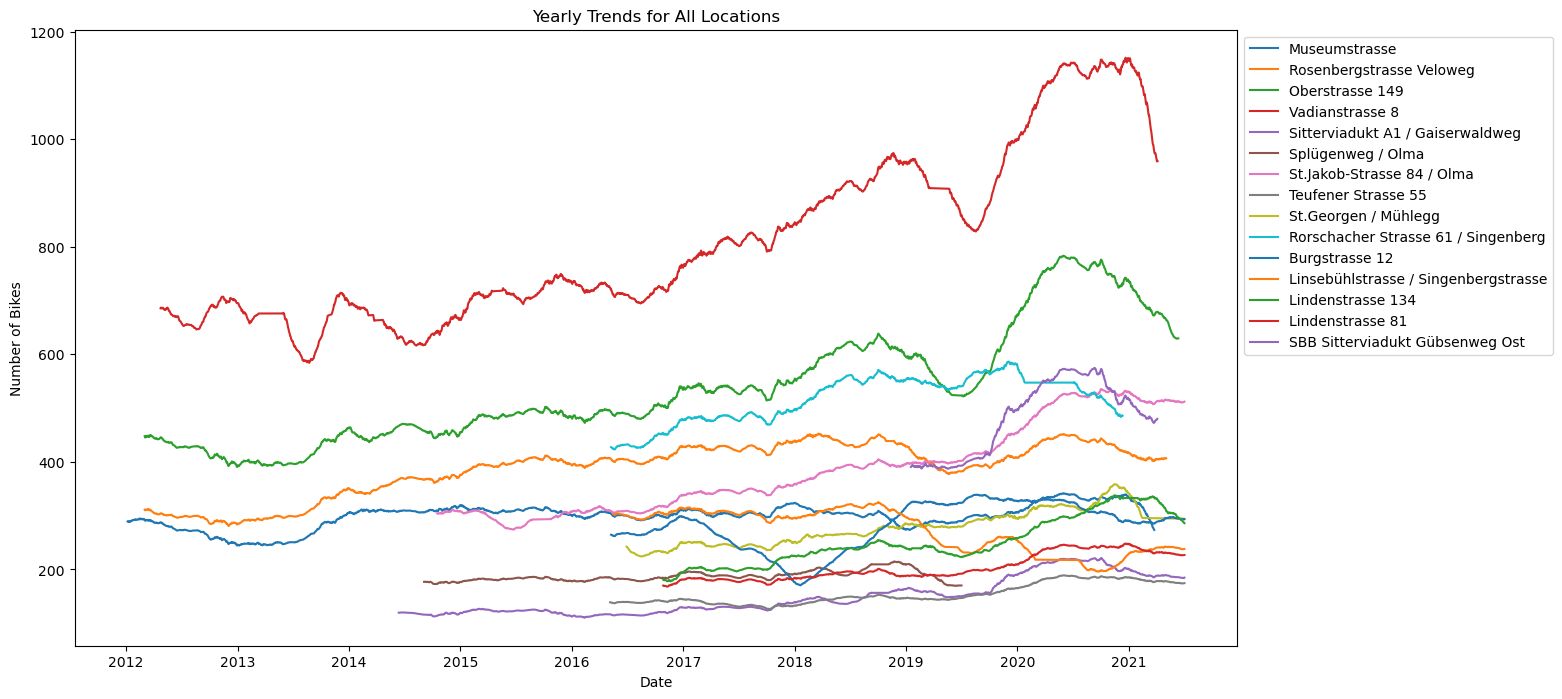

In [23]:
# Visualizing yearly trends for each location reveals varied trend lines of different lengths
# Different activity levels across distinct years for individual location

trends = {}
df2 = df.copy()

for ort in orte:
    # Make sure "Datum" is a datetime
    df2 = df_dict[ort].copy()
    df2["Datum"] = pd.to_datetime(df2["Datum"])
    
    # Temporarily set "Datum" as the DataFrame index for decomposition
    df_temp = df2.set_index("Datum")
    
    # Make sure "Anzahl Velos" is a float
    time_series = df_temp["Anzahl Velos"].astype(float)
    
    # Seasonal decomposition
    # "Additive" as seasonal variation is relatively stable. Becomes more clear in the trend/seasonality decomposition further down
    decomposition_yearly = seasonal_decompose(time_series, model="additive", period=365) 
    
    trends[ort] = decomposition_yearly.trend

plt.figure(figsize=(15, 8))
for ort, trend in trends.items():
    # Drop NaN values that result from the decomposition at the start and end
    # Also, use the index from the trend series which corresponds to "Datum"
    plt.plot(trend.dropna().index, trend.dropna(), label=ort)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.title("Yearly Trends for All Locations")
plt.xlabel("Date")
plt.ylabel("Number of Bikes")
#plt.savefig("Project/yearly trends all locations.png", bbox_inches="tight")

plt.show()

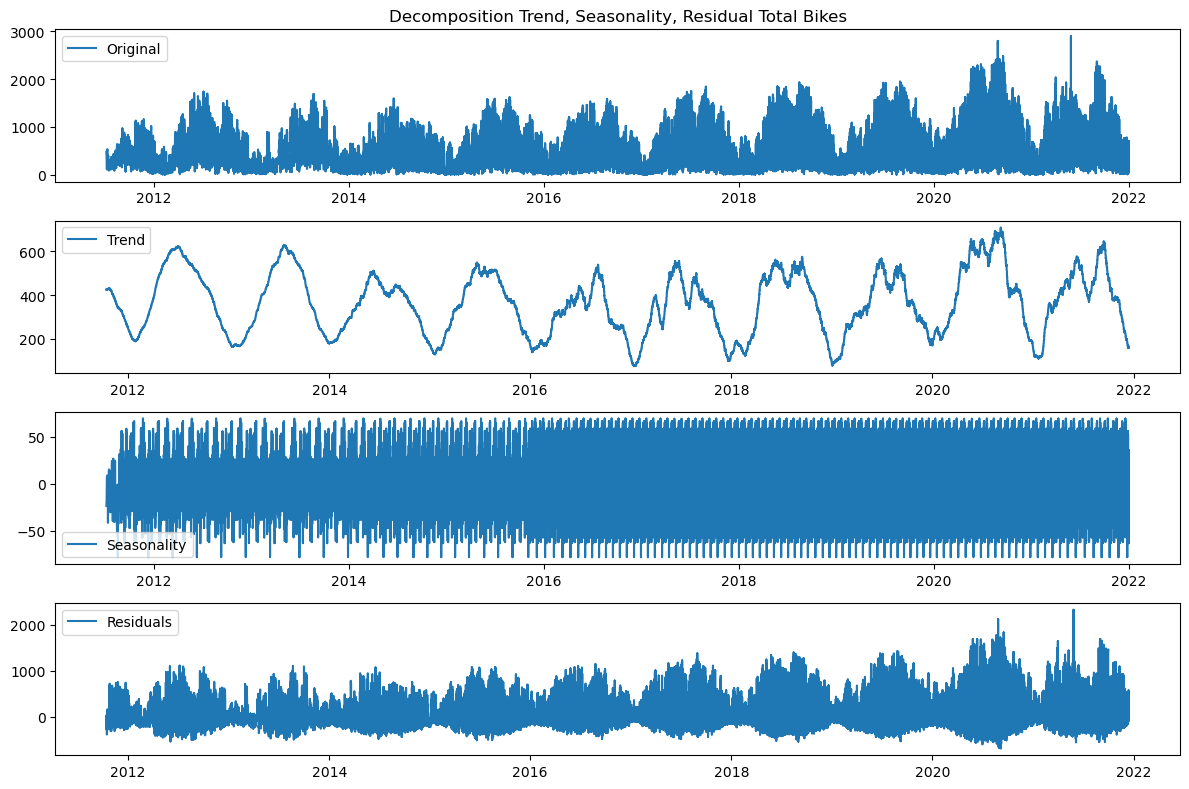

In [24]:
# Decomposing the "Anzahl Velos" column to analyze its components

df_copy = df.copy()
decomposition = seasonal_decompose(df_copy["Anzahl Velos"], model="additive", period=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting the original data, trend, seasonality, and residuals in separate subplots
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_copy["Datum"], df_copy["Anzahl Velos"], label="Original")
plt.legend(loc="best")
plt.title("Decomposition Trend, Seasonality, Residual Total Bikes")  

plt.subplot(412)
plt.plot(df_copy["Datum"], trend, label="Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(df_copy["Datum"], seasonal, label="Seasonality")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(df_copy["Datum"], residual, label="Residuals")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Multiple entries per day and double seasonality (yearly and weekly) create problems when decomposing.
Therefore, we analyze Museumsstrasse as an example.

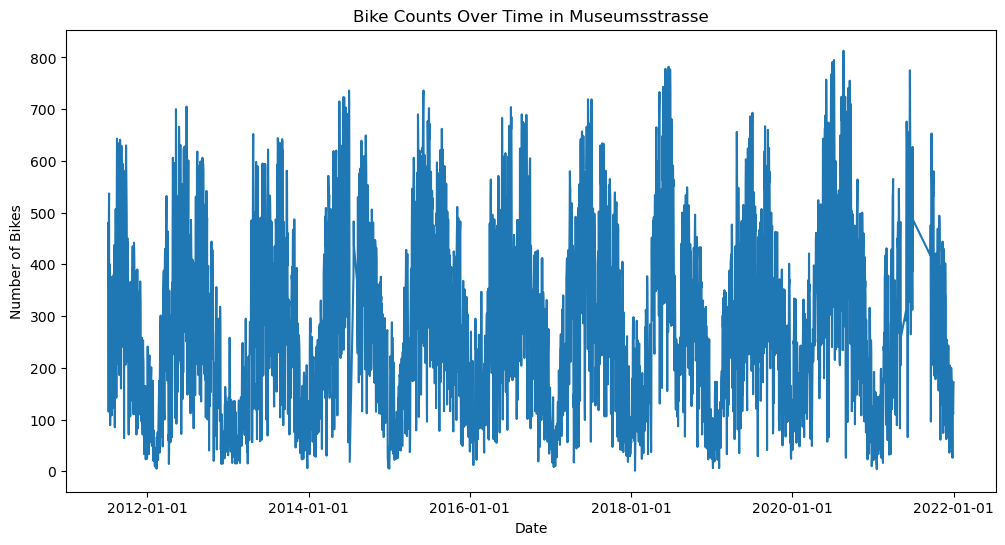

In [25]:
# Creating a plot to visualize bike counts over time for Museumstrasse as an example (to avoid issues with multiple entries per day as there are several counting locations)

df_museum = df[df["Bezeichnung"] == "Museumstrasse"]
plt.figure(figsize=(12, 6))

plt.plot(df_museum["Datum"], df_museum["Anzahl Velos"])  
plt.title("Bike Counts Over Time in Museumsstrasse")  
plt.xlabel("Date")  
plt.ylabel("Number of Bikes")  


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

#plt.savefig("Project/bike counts over time Museumstrasse.png", bbox_inches="tight")


plt.show() 

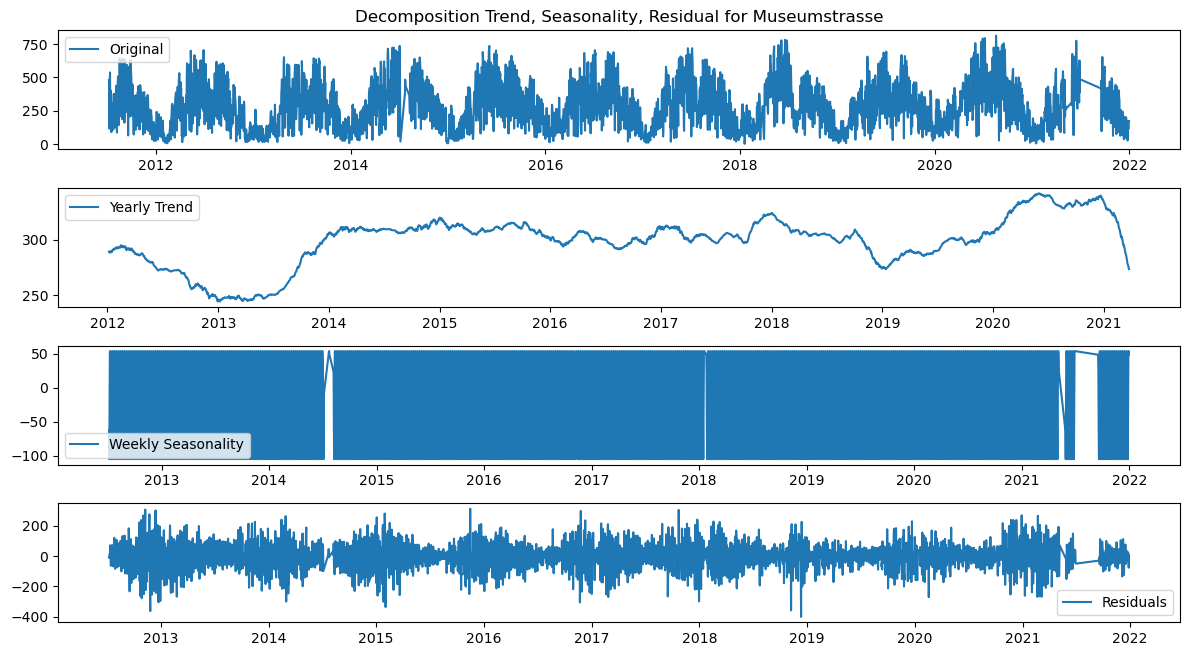

In [26]:
# Filtering the dataframe for "Museumstrasse" for illustration purposes (to avoid issues with multiple entries per day as there are several counting locations)

# Yearly decomposition
decomposition_yearly = seasonal_decompose(df_museum["Anzahl Velos"], model="additive", period =365)
trend_yearly = decomposition_yearly.trend
residual_yearly = decomposition_yearly.resid

# Weekly decomposition
decomposition_weekly = seasonal_decompose(residual_yearly.dropna(), model="additive", period=7)
trend_weekly = decomposition_weekly.trend
seasonal_weekly = decomposition_weekly.seasonal
residual = decomposition_weekly.resid

plt.figure(figsize=(12, 8))

# Original data
plt.subplot(511)
plt.plot(df_museum["Datum"], df_museum["Anzahl Velos"], label="Original")
plt.legend(loc="best")
plt.title("Decomposition Trend, Seasonality, Residual for Museumstrasse")  


# Yearly trend
plt.subplot(512)
plt.plot(df_museum["Datum"], trend_yearly, label="Yearly Trend")
plt.legend(loc="best")

# Weekly seasonality
plt.subplot(513)
plt.plot(df_museum["Datum"][len(df_museum) - len(seasonal_weekly):], seasonal_weekly, label="Weekly Seasonality")
plt.legend(loc="best")

# Combined residuals
plt.subplot(514)
plt.plot(df_museum["Datum"][len(df_museum) - len(residual):], residual, label="Residuals")
plt.legend(loc="best")


plt.tight_layout()
#plt.savefig("Project/decompose Museumstrasse.png", bbox_inches="tight")

plt.show()

The seasonality looks weird due to the high number of entries. To provide a useful plot we analyze the weekly seasonality during a few months in 2019 for Muesuemstrase. See below. 

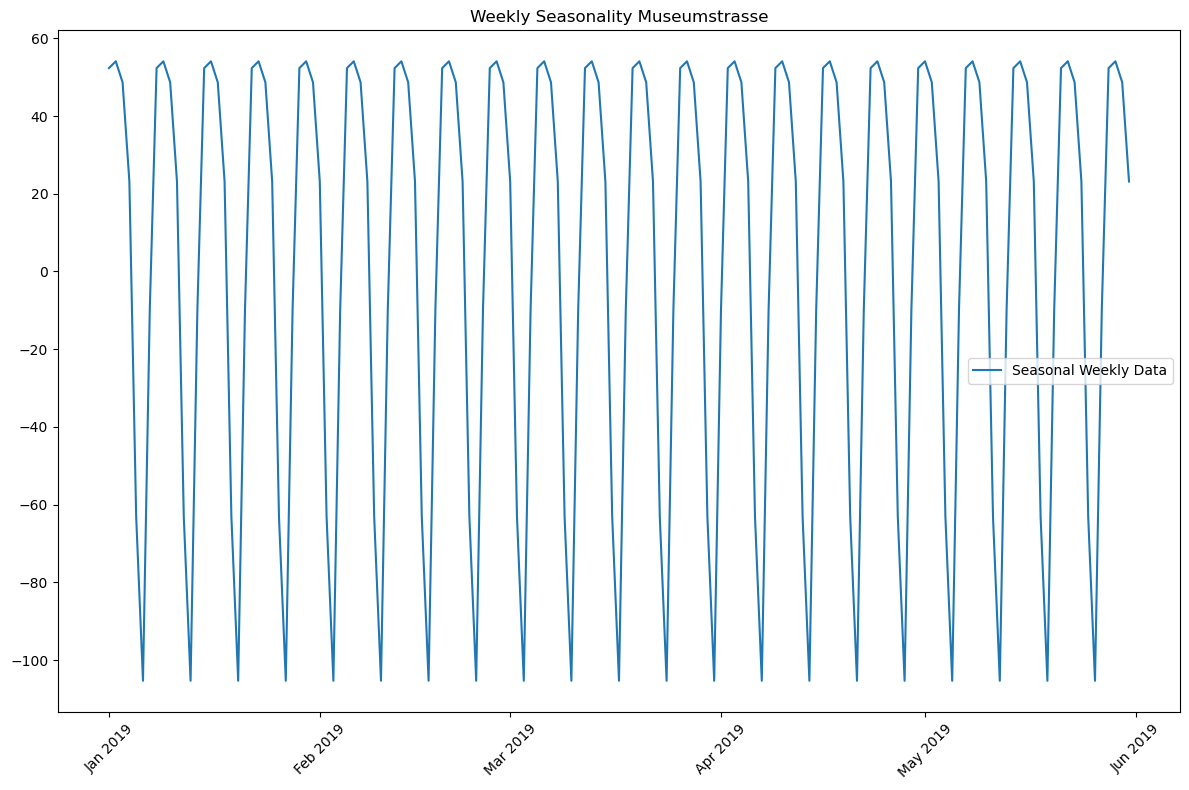

In [60]:
# Selecting a specific period to explore the weekly seasonality 
# Visible in the decomposed graph as well as in the correlation between "Anzahl Velos" and weekdays v.s. weekends
start_date = pd.to_datetime("2019-01-01")
end_date = pd.to_datetime("2019-05-31")
mask = (df_museum["Datum"] >= start_date) & (df_museum["Datum"] <= end_date)

plt.figure(figsize=(12, 8))

# Weekly Seasonality for the selected time frame
plt.subplot(111)
plt.plot(df_museum["Datum"][mask], seasonal_weekly[mask], label="Seasonal Weekly Data")
plt.legend(loc="best")
plt.title("Weekly Seasonality Museumstrasse")


plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)  # Rotate for better readability

plt.tight_layout()
plt.show()


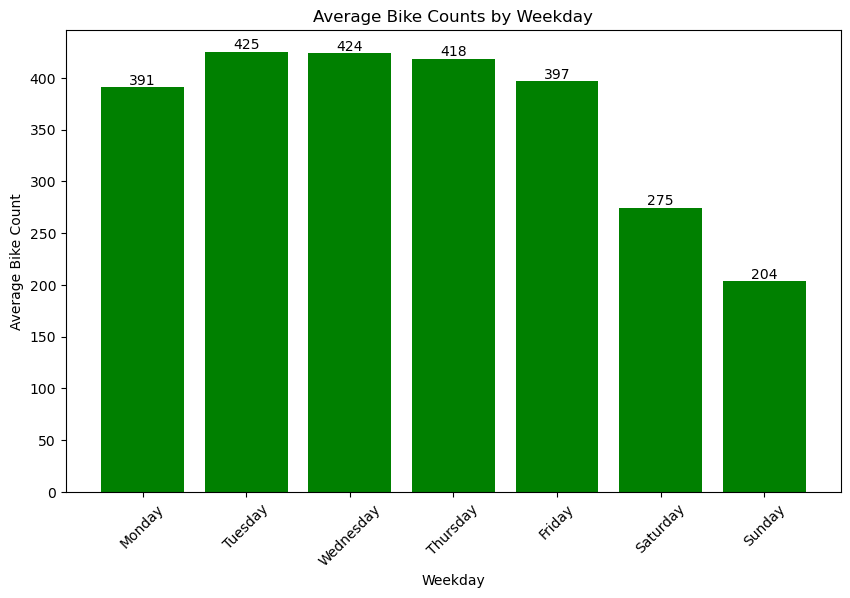

In [28]:
# The plot above reveals weekly drops, which are likely to be due to the weekend. 
# To further explore this, we plot the average number of cyclists per weekday.

# Creating subdatasets for each weekday
df_montag = df[df["Montag"] == True]
df_dienstag = df[df["Dienstag"] == True]
df_mittwoch = df[df["Mittwoch"] == True]
df_donnerstag = df[df["Donnerstag"] == True]
df_freitag = df[df["Freitag"] == True]
df_samstag = df[df["Samstag"] == True]
df_sonntag = df[df["Sonntag"] == True]

# Calculating the mean for every weekday
mean_montag = df_montag["Anzahl Velos"].mean()
mean_dienstag = df_dienstag["Anzahl Velos"].mean()
mean_mittwoch = df_mittwoch["Anzahl Velos"].mean()
mean_donnerstag = df_donnerstag["Anzahl Velos"].mean()
mean_freitag = df_freitag["Anzahl Velos"].mean()
mean_samstag = df_samstag["Anzahl Velos"].mean()
mean_sonntag = df_sonntag["Anzahl Velos"].mean()

# Creating a list with the values and the labels for the plot
mean_weekdays = [mean_montag, mean_dienstag, mean_mittwoch, mean_donnerstag, mean_freitag, mean_samstag, mean_sonntag]
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Creating a plot
plt.figure(figsize=(10, 6))  
bars = plt.bar(weekdays, mean_weekdays, color="green")  

# Creating the number over the bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), ha="center", va="bottom")

# Setting title and labels
plt.title("Average Bike Counts by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Average Bike Count")

plt.xticks(rotation=45)
#plt.savefig("Project/average bike counts weekday.png", bbox_inches="tight")


plt.show()

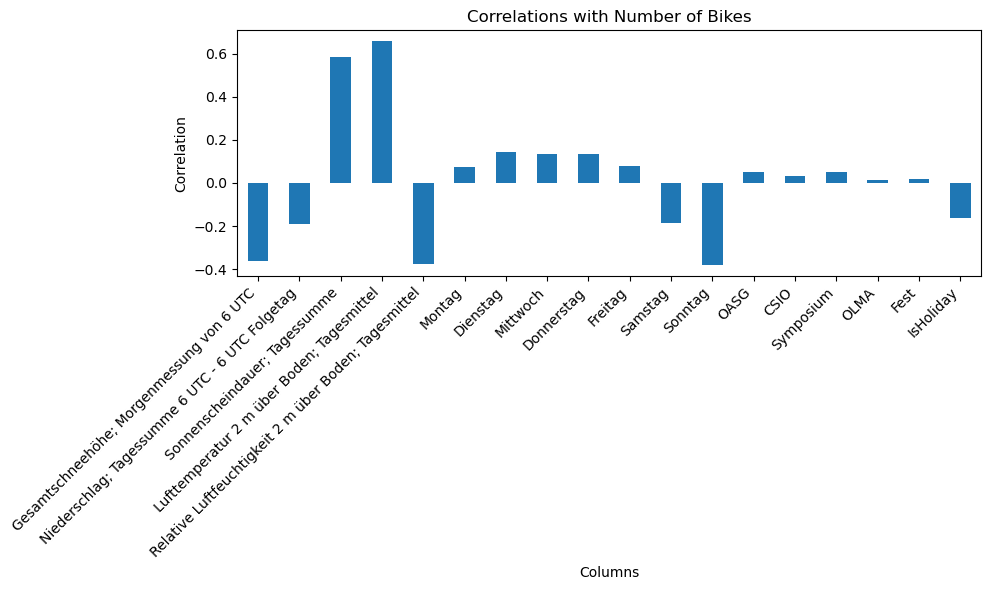

In [29]:
# Correlation Analysis for "Anzahl Velos" and specific features like weather or day data

selected_column = "Anzahl Velos"  

# Columns to exclude from correlation analysis
columns_to_exclude = ["Bezeichnung", "Monat_sinus", "Monat_cosinus", "Datum", "Jahr", "Jahr skaliert", "Anzahl Velos", "Monat"] 


columns_to_drop = [col for col in columns_to_exclude if col in df_museum.columns]
df_for_correlation = df_museum.drop(columns=columns_to_drop, errors="ignore")

correlations_with_selected = df_for_correlation.corrwith(df_museum[selected_column])

# Creating a plot and setting title, labels and ticks
plt.figure(figsize=(10, 6))
correlations_with_selected.plot(kind="bar")
plt.title("Correlations with Number of Bikes")
plt.xlabel("Columns")
plt.ylabel("Correlation")
plt.xticks(rotation=45, ha="right")  
plt.tight_layout()


plt.show()

Explore the Autocorrelation Function through the residual plot to uncover any remaining pattern within the data (linear relationship between lagged values). This step is important as our data's observations are not independent of each other. 

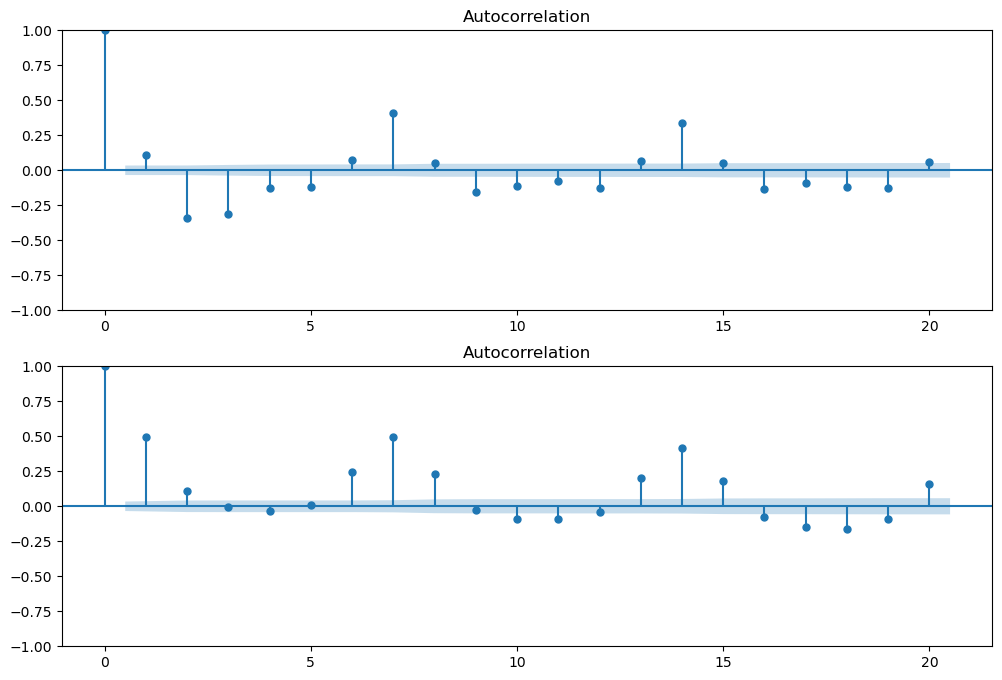

In [30]:
# Drop NaNs in the residual to ensure accurate Autocorrelation Function (ACF) computation
residual_nonan = residual.dropna()  
residual_nonan_yearly = residual_yearly.dropna()  


fig, axs = plt.subplots(2, 1, figsize=(12, 8))  
plot_acf(residual_nonan, lags=20, ax=axs[0])  # ACF for daily residuals 
plot_acf(residual_nonan_yearly, lags=20, ax=axs[1])  # ACF for yearly residuals s
plt.show()  

# If bars are outside the blue shaded area, the autocorrelation at this lag might be statistically significant 

These two ACF plots show that both the single and the double seasonality decomposition did not manage to get rid of all the seasonality. Employing more sophisticated models such as ARIMA or TBATS would not make too much sense, as the seasonality has to be part of our prediction model. The decomposition above was only done for visualization reasons.

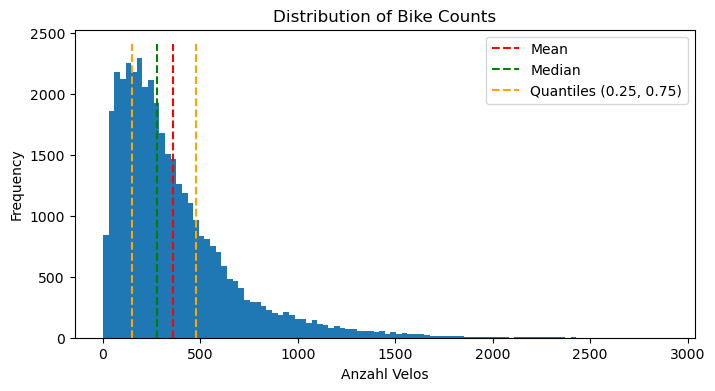

count    38071.000000
mean       361.718132
std        306.335655
min          1.000000
25%        149.000000
50%        278.000000
75%        479.000000
max       2892.000000
Name: Anzahl Velos, dtype: float64

In [31]:
# Check whether our data is in a sensible range or whether there are strong outliers

fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(df["Anzahl Velos"], bins=100)

# Draw the mean and median lines
ymax = ax.get_ylim()[1]  
ax.vlines([df["Anzahl Velos"].mean()], ymin=0, ymax=ymax, linestyles="dashed", 
          colors=["red"], label="Mean")
ax.vlines([df["Anzahl Velos"].median()], ymin=0, ymax=ymax, linestyles="dashed",
          colors=["green"], label="Median")

ax.vlines([df["Anzahl Velos"].quantile(0.25), df["Anzahl Velos"].quantile(0.75)], ymin=0, ymax=ymax,
          linestyles="dashed", colors=["orange", "orange"], label="Quantiles (0.25, 0.75)")



# Setting title, labels and legend
ax.legend()
ax.set_xlabel("Anzahl Velos")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Bike Counts")

plt.show()
df["Anzahl Velos"].describe()

- The mean (812.15) is higher than the median/0.5th quantile (746.0)
- The distribution is slightly right-skewed, i.e. the mean gets influenced by extreme value.
- Performance of statistical models could get influenced, as e.g. linear models are more sensitive to a skewed distribution (they assume constant variance) or some statistical models simply assume normal distribution.

In [32]:
# Addressing the skewness and try log transformation (to assure a linear relationship)

df_log = df.copy()

# Including an offset of 1 to avoid log(0)
df_log["Anzahl Velos"] = np.log(df_log["Anzahl Velos"] + 1)

# Renaming the transformed column
df_log.rename(columns={"Anzahl Velos": "Log_Anzahl_Velos"}, inplace=True)


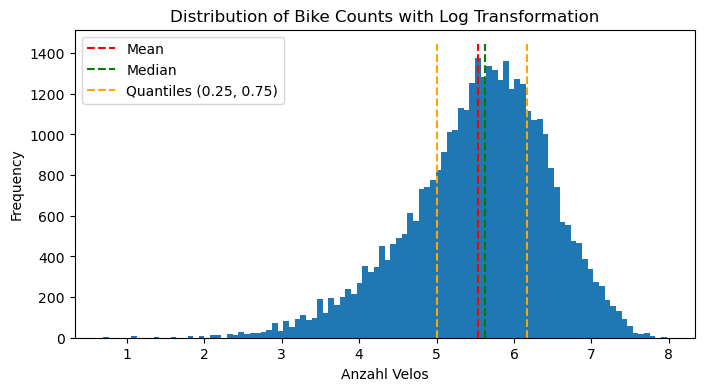

count    38071.000000
mean         5.540082
std          0.911441
min          0.693147
25%          5.010635
50%          5.631212
75%          6.173786
max          7.970049
Name: Log_Anzahl_Velos, dtype: float64

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(df_log["Log_Anzahl_Velos"], bins=100)

# Draw the mean and median lines
ymax = ax.get_ylim()[1]  
ax.vlines([df_log["Log_Anzahl_Velos"].mean()], ymin=0, ymax=ymax, linestyles="dashed",
          colors=["red"], label="Mean")
ax.vlines([df_log["Log_Anzahl_Velos"].median()], ymin=0, ymax=ymax, linestyles="dashed",
          colors=["green"], label="Median")

# Draw 0.25, 0.75 quantiles
ax.vlines([df_log["Log_Anzahl_Velos"].quantile(0.25), df_log["Log_Anzahl_Velos"].quantile(0.75)],
          ymin=0, ymax=ymax, linestyles="dashed", colors=["orange", "orange"], label="Quantiles (0.25, 0.75)")

# setting title, labels and legend
ax.legend()
ax.set_xlabel("Anzahl Velos")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Bike Counts with Log Transformation")

plt.show()
df_log["Log_Anzahl_Velos"].describe()


In [34]:
# Addressing the skewness and try Yeo Johnson transformation (for any types of data transforms features)

pt = PowerTransformer(method="yeo-johnson")
df_yeo = df.copy()
df_yeo["Anzahl Velos"] = pt.fit_transform(df_yeo["Anzahl Velos"].values.reshape(-1, 1))

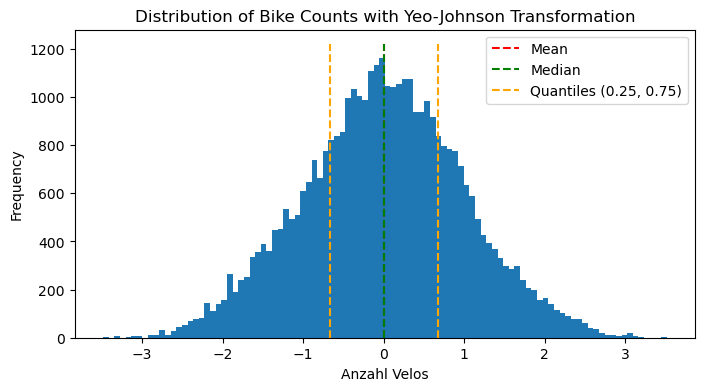

count    3.807100e+04
mean    -2.448667e-16
std      1.000013e+00
min     -3.486830e+00
25%     -6.636598e-01
50%      5.181519e-03
75%      6.684023e-01
max      3.513812e+00
Name: Anzahl Velos, dtype: float64

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(df_yeo["Anzahl Velos"], bins=100)

# Draw the mean and median lines
ymax = ax.get_ylim()[1]  # Maximum of the y-axis
ax.vlines([df_yeo["Anzahl Velos"].mean()], ymin=0, ymax=ymax, linestyles="dashed",
          colors=["red"], label="Mean")
ax.vlines([df_yeo["Anzahl Velos"].median()], ymin=0, ymax=ymax, linestyles="dashed",
          colors=["green"], label="Median")

# Draw 0.25, 0.75 quantiles
ax.vlines([df_yeo["Anzahl Velos"].quantile(0.25), df_yeo["Anzahl Velos"].quantile(0.75)],
          ymin=0, ymax=ymax, linestyles="dashed", colors=["orange", "orange"], label="Quantiles (0.25, 0.75)")

ax.legend()
ax.set_xlabel("Anzahl Velos")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Bike Counts with Yeo-Johnson Transformation")

plt.show()
df_yeo["Anzahl Velos"].describe()


In our analysis, we've noticed that the correlation between the features and the label might be different for each location which is why we will train a model for every location by creating sub-data frames. 

We explore models to identify the most effective one for our prediction task. We use the Times Seris Cross Validator as a variation of K-fold as we are dealing with time series data.
- Ridge Regresssion
- Lasso Regression
- Random Forest

In [36]:
df_dict_log = {}

for ort in orte:
    df_dict_log[ort] = df_log[df_log["Bezeichnung"] == ort]

In [37]:
# Ridge Regression with no transformation
# Looping through locations and applying Ridge Regression within each split

# Creating dictionaries to store the MAE and MSE values
mse_scores_dict_ridge = {}
mae_scores_dict_ridge = {}

# Looping over all the locations
for ort in names:
    df1 = df_dict[ort]
    X_2 = df1.drop(columns=["Anzahl Velos", "Datum", "Monat", "Jahr", "Bezeichnung"])
    y_2 = df1["Anzahl Velos"]
    tss = TimeSeriesSplit(n_splits=5) # Perform CV for Timeseries

    # Creating lists to store the MSE and MAE values for every time series split
    mse_scores = []
    mae_scores = []

    for train_index, test_index in tss.split(X_2):

        X_train_2, X_test_2 = X_2.iloc[train_index, :], X_2.iloc[test_index, :]
        y_train_2, y_test_2 = y_2.iloc[train_index], y_2.iloc[test_index]

        # Fitting the model on the current split
        ridge = Ridge()  
        ridge.fit(X_train_2, y_train_2)  

        # Predicting for each split
        y_pred_2 = ridge.predict(X_test_2)
        
        # Calculating and storing the MSE and MAE values
        mse = mean_squared_error(y_test_2, y_pred_2)
        mae = mean_absolute_error(y_test_2, y_pred_2)
        mse_scores.append(mse)
        mae_scores.append(mae)

    # Adding the MAE and MSE average to the dictionary for each location 
    mse_scores_dict_ridge[ort] = np.mean(mse_scores)
    mae_scores_dict_ridge[ort] = np.mean(mae_scores)

In [38]:
# Creating a dictionary to store dataframes for each location with preceeding log transformation
df_dict_log = {}

for ort in orte:
    df_dict_log[ort] = df_log[df_log["Bezeichnung"] == ort]


In [39]:
# Ridge Regression with log transformation
# Looping through locations and applying Ridge Regression within each split

# Creating dictionaries to store the MAE and MSE values
mse_scores_dict_ridge_log = {}
mae_scores_dict_ridge_log = {}

# Looping over all the locations
for ort in names:
    df1 = df_dict_log[ort]
    X_2 = df1.drop(columns=["Log_Anzahl_Velos", "Datum", "Monat", "Jahr", "Bezeichnung"])
    y_2 = df1["Log_Anzahl_Velos"]
    tss = TimeSeriesSplit(n_splits=5) # Perform CV for Timeseries

    # creating lists to store the MSE and MAE values for every time series split
    mse_scores = []
    mae_scores = []
   

    for train_index, test_index in tss.split(X_2):
        
        X_train_2, X_test_2 = X_2.iloc[train_index, :], X_2.iloc[test_index, :]
        y_train_2, y_test_2 = y_2.iloc[train_index], y_2.iloc[test_index]

        # Fitting the model on the current split
        ridge = Ridge()  
        ridge.fit(X_train_2, y_train_2)  

        # Predicting for each split
        y_pred_transformed_2 = ridge.predict(X_test_2)

        # Inverse transform predictions to original scale
        y_pred_back = np.exp(y_pred_transformed_2)

        # Calculating and storing the MSE and MAE values
        mse = mean_squared_error(y_pred_back, y_test_2)
        mae = mean_absolute_error(y_pred_back, y_test_2)
        mse_scores.append(mse)
        mae_scores.append(mae)

    # Adding the MAE and MSE average to the dictionary for each location     
    mse_scores_dict_ridge_log[ort] = np.mean(mse_scores)
    mae_scores_dict_ridge_log[ort] = np.mean(mae_scores)

In [40]:
# Ridge Regression with Yeo Johnsonn transformation
# Looping through locations and applying Ridge Regression within each split

# Creating dictionaries to store the MAE and MSE values
mse_scores_dict_ridge_yeo = {}
mae_scores_dict_ridge_yeo = {}

# Looping over all the locations
for ort in names:
    df1 = df_dict[ort]
    X_2 = df1.drop(columns=["Anzahl Velos", "Datum", "Monat", "Jahr", "Bezeichnung"])
    y_2 = df1["Anzahl Velos"]
    tss = TimeSeriesSplit(n_splits=5) # Perform CV for Timeseries
    pt = PowerTransformer(method="yeo-johnson")

    # creating lists to store the MSE and MAE values for every time series split
    mse_scores = []
    mae_scores = []

    for train_index, test_index in tss.split(X_2):
        
        X_train_2, X_test_2 = X_2.iloc[train_index, :], X_2.iloc[test_index, :]
        y_train_2, y_test_2 = y_2.iloc[train_index], y_2.iloc[test_index]

        # Apply Yeo-Johnson transformation to target variable
        y_train_transformed_2 = pt.fit_transform(y_train_2.values.reshape(-1, 1))
        y_test_transformed_2 = pt.transform(y_test_2.values.reshape(-1, 1))

        # Fitting the model on the current split
        ridge = Ridge()  
        ridge.fit(X_train_2, y_train_transformed_2)  

         # predicting for each split
        y_pred_transformed_2 = ridge.predict(X_test_2)

        # Inverse transform predictions to original scale
        y_pred_2 = pt.inverse_transform(y_pred_transformed_2.reshape(-1, 1))

        # Calculating and storing the MSE and MAE values
        mse = mean_squared_error(y_test_2, y_pred_2)
        mae = mean_absolute_error(y_test_2, y_pred_2)
        mse_scores.append(mse)
        mae_scores.append(mae)

    # Adding the MAE and MSE average to the dictionary for each location  
    mse_scores_dict_ridge_yeo[ort] = np.mean(mse_scores)
    mae_scores_dict_ridge_yeo[ort] = np.mean(mae_scores)

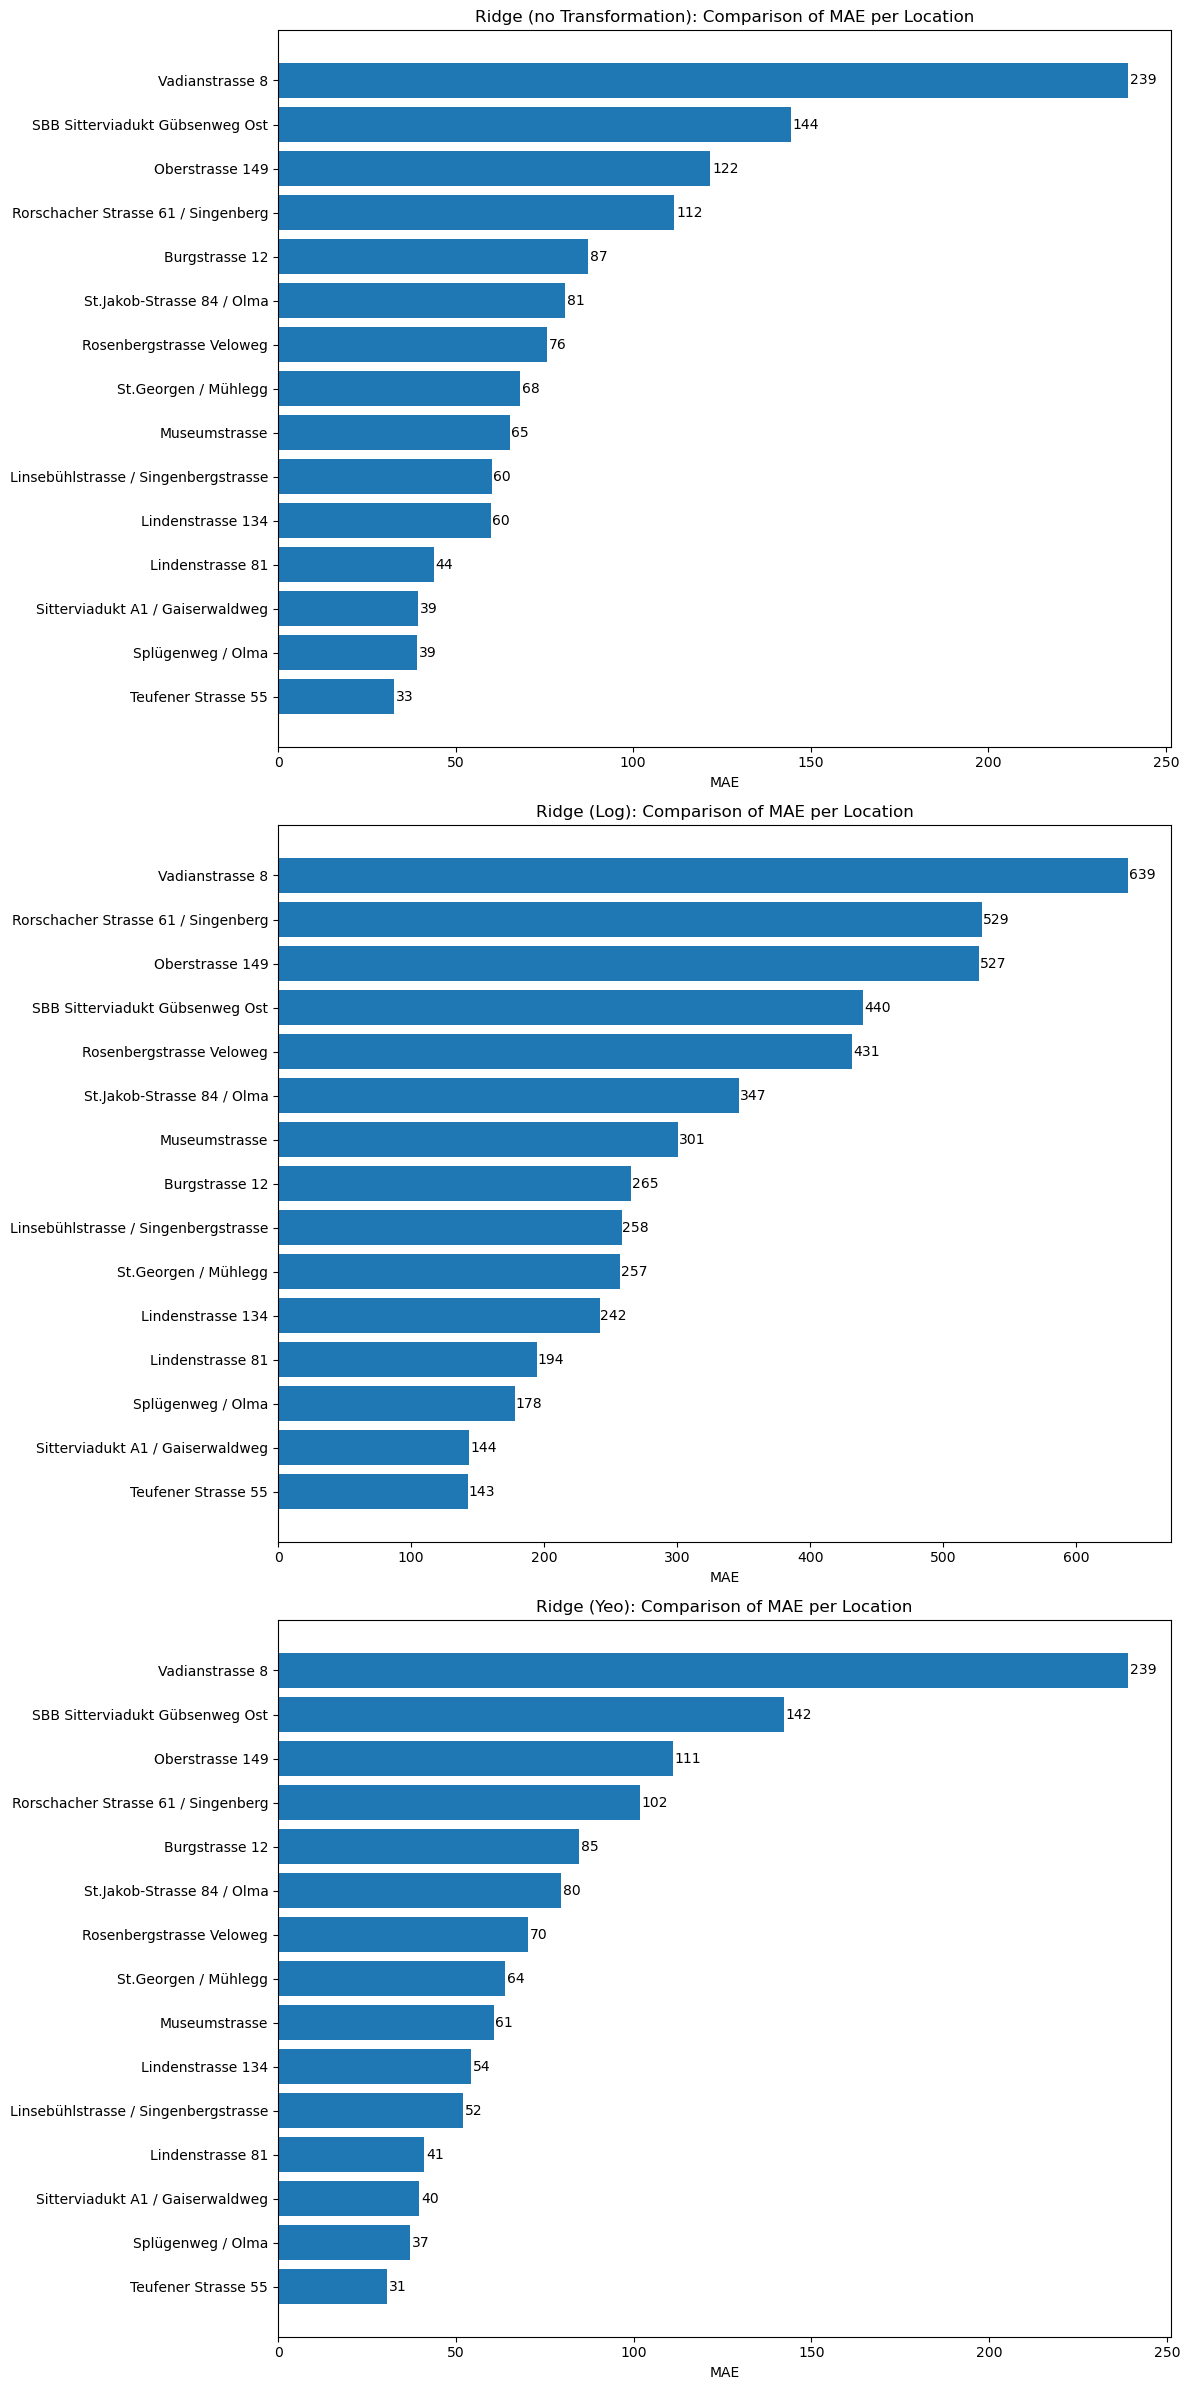

In [41]:
# Visualise MAE for the Ridge Regression Model with different (or none) Transformation technique for different locations.

fig, axs = plt.subplots(3, 1, figsize=(12, 24))  # 3 rows, 1 column

# Plot for Ridge (no transformation)
names = list(mae_scores_dict_ridge.keys())

# Sorting the names in the bar chart by length
mae = [mae_scores_dict_ridge[ort] for ort in names]
sorted_pairs = sorted(zip(mae, names))
mae, names = zip(*sorted_pairs)
axs[0].barh(names, mae)

# Creating the number behind the bar
for bar in axs[0].containers[0]:
    width = bar.get_width()
    label_x_pos = width + 0.5
    axs[0].text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{width:.0f}", va="center")

# Cetting the title and label
axs[0].set_xlabel("MAE")
axs[0].set_title("Ridge (no Transformation): Comparison of MAE per Location")

# Repeating the steps from above for Ridge with log Transformation
names = list(mae_scores_dict_ridge_log.keys())
mae = [mae_scores_dict_ridge_log[ort] for ort in names]
sorted_pairs = sorted(zip(mae, names))
mae, names = zip(*sorted_pairs)
axs[1].barh(names, mae)
for bar in axs[1].containers[0]:
    width = bar.get_width()
    label_x_pos = width + 0.5
    axs[1].text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{width:.0f}", va="center")
axs[1].set_xlabel("MAE")
axs[1].set_title("Ridge (Log): Comparison of MAE per Location")


# Repeating the steps from above for Ridge with Yeo-Johnson Transformation
names = list(mae_scores_dict_ridge_yeo.keys())
mae = [mae_scores_dict_ridge_yeo[ort] for ort in names]
sorted_pairs = sorted(zip(mae, names))
mae, names = zip(*sorted_pairs)
axs[2].barh(names, mae)
for bar in axs[2].containers[0]:
    width = bar.get_width()
    label_x_pos = width + 0.5
    axs[2].text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{width:.0f}", va="center")
axs[2].set_xlabel("MAE")
axs[2].set_title("Ridge (Yeo): Comparison of MAE per Location")



plt.tight_layout()
plt.show()

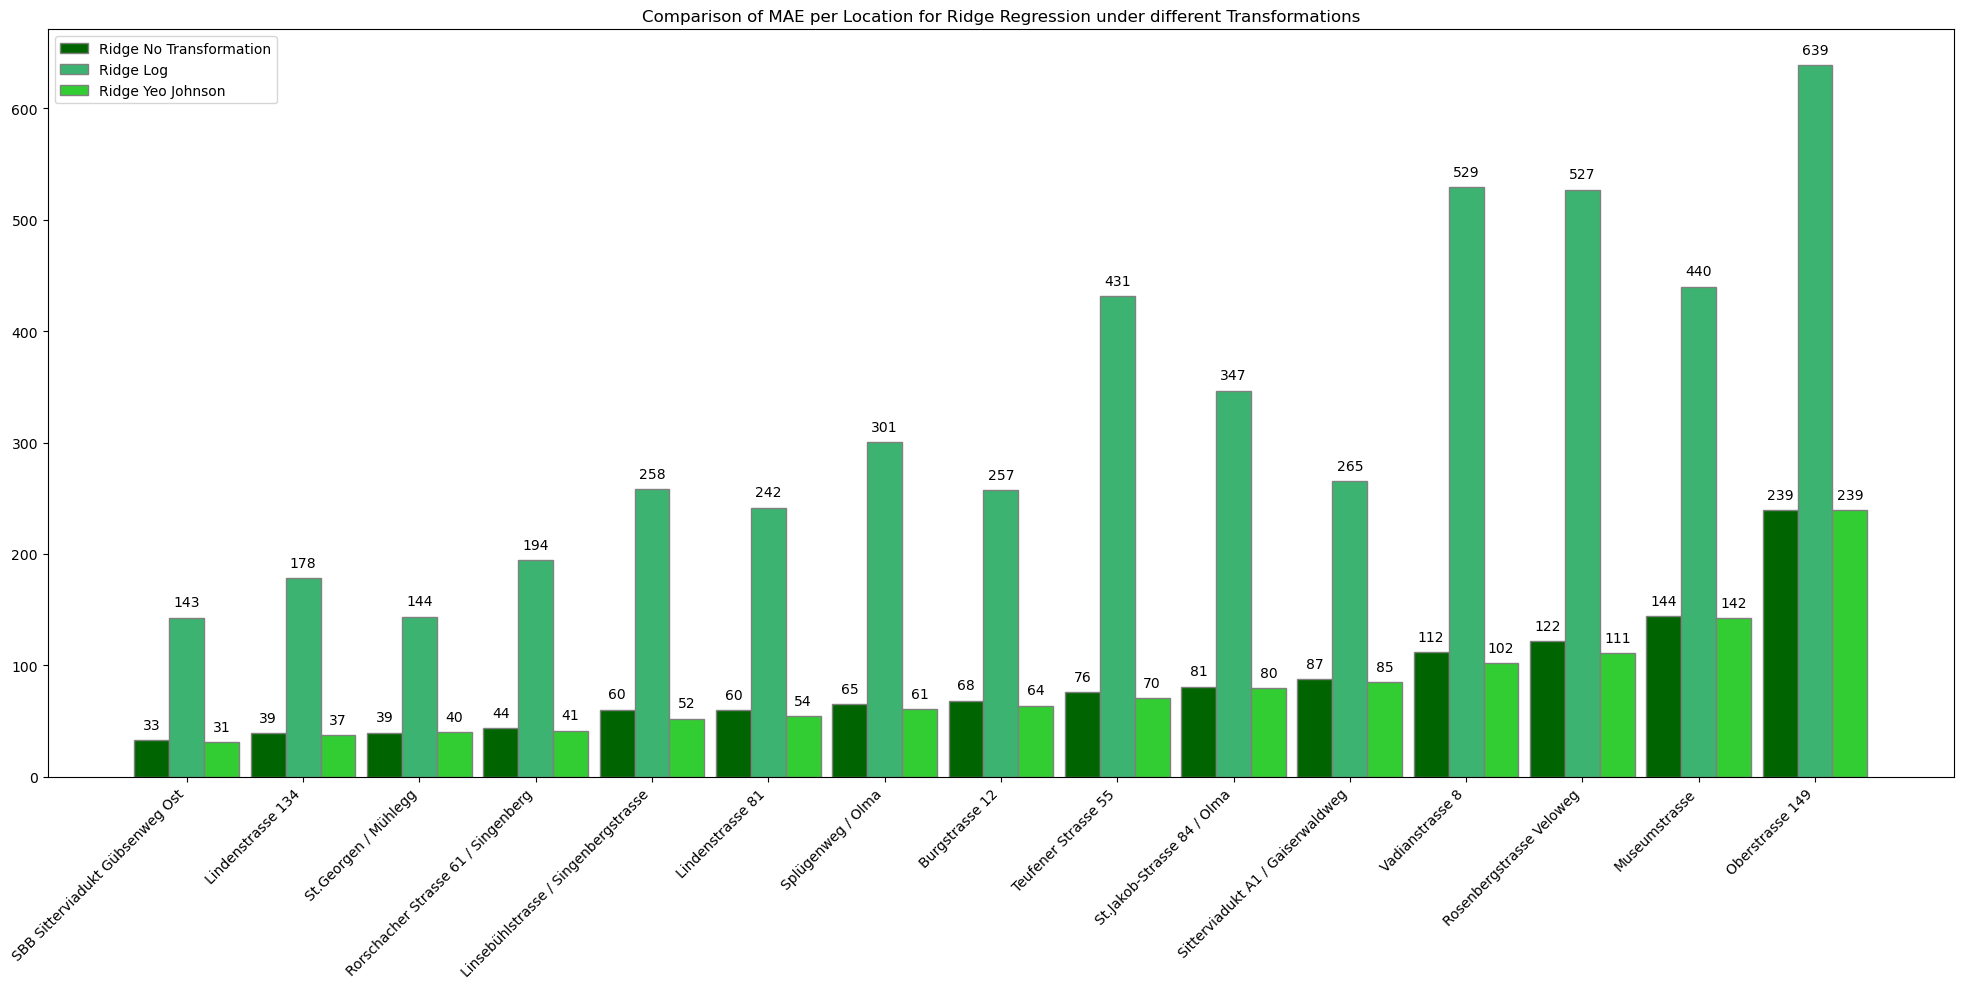

In [42]:
# Visualise MAE for the Lasso Regression Model with different (or none) Transformation technique for different locations in one plot

locations = list(mae_scores_dict_ridge.keys())
mae = [mae_scores_dict_ridge[ort] for ort in names]
mae_log = [mae_scores_dict_ridge_log[ort] for ort in names]
mae_yeo = [mae_scores_dict_ridge_yeo[ort] for ort in names]

# Number of locations
n_locations = len(locations)

barWidth = 0.3
r1 = np.arange(n_locations)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bars with new colors
plt.figure(figsize=(20, 10))
plt.bar(r1, mae, color="darkgreen", width=barWidth, edgecolor="grey", label="Ridge No Transformation")
plt.bar(r2, mae_log, color="mediumseagreen", width=barWidth, edgecolor="grey", label="Ridge Log")
plt.bar(r3, mae_yeo, color="limegreen", width=barWidth, edgecolor="grey", label="Ridge Yeo Johnson")


vertical_offset = max(max(mae), max(mae_log), max(mae_yeo)) * 0.01  

# Function to add value labels on top of the bars
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = "bottom"
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.0f}".format(y_value)
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha="center",                
            va=va)                      


add_value_labels(plt.gca(), spacing=int(vertical_offset))

plt.xticks([r + barWidth for r in r1], locations, rotation=45, ha="right")

plt.legend()
plt.title("Comparison of MAE per Location for Ridge Regression under different Transformations")

plt.tight_layout()  
plt.show()

In [43]:
# Calculate the means and the Median of MAE and MSE

# Calculate mean and median for MAE (no transformation)
mae_values_normal = list(mae_scores_dict_ridge.values())
mae_mean_normal = np.mean(mae_values_normal)
mae_median_normal = np.median(mae_values_normal)

mse_values_normal = list(mse_scores_dict_ridge.values())
mse_mean_normal = np.mean(mse_values_normal)
mse_median_normal = np.median(mse_values_normal)

# Calculate mean and median for MAE (yeo-johnson transformation)
mae_values_yeo = list(mae_scores_dict_ridge_yeo.values())
mae_mean_yeo = np.mean(mae_values_yeo)
mae_median_yeo = np.median(mae_values_yeo)

mse_values_yeo = list(mse_scores_dict_ridge_yeo.values())
mse_mean_yeo = np.mean(mse_values_yeo)
mse_median_yeo = np.median(mse_values_yeo)


# Calculate mean and median for MAE (log transformation)
mae_values_log = list(mae_scores_dict_ridge_log.values())
mae_mean_log = np.mean(mae_values_log)
mae_median_log = np.median(mae_values_log)

mse_values_log = list(mse_scores_dict_ridge_log.values())
mse_mean_log = np.mean(mse_values_log)
mse_median_log = np.median(mse_values_log)

print("MAE Ridge (No Transformation):")
print(f"Mean: {mae_mean_normal}, Median: {mae_median_normal}")

print("MAE Ridge(Yeo-Johnson Transformation):")
print(f"Mean: {mae_mean_yeo}, Median: {mae_median_yeo}")

print("MAE Ridge (Log Transformation):")
print(f"Mean: {mae_mean_log}, Median: {mae_median_log}")

print("MSE Ridge (No Transformation):")
print(f"Mean: {mse_mean_normal}, Median: {mse_median_normal}")

print("MSE Ridge (Yeo-Johnson):")
print(f"Mean: {mse_mean_yeo}, Median: {mse_median_yeo}")

print("MSE Ridge (Log Transformation):")
print(f"Mean: {mse_mean_log}, Median: {mse_median_log}")


MAE Ridge (No Transformation):
Mean: 84.6359807295606, Median: 68.23446437036095
MAE Ridge(Yeo-Johnson Transformation):
Mean: 80.53624791426601, Median: 63.769231660738434
MAE Ridge (Log Transformation):
Mean: 326.3260264877803, Median: 265.4718252903241
MSE Ridge (No Transformation):
Mean: 17239.56916161324, Median: 9159.000679649205
MSE Ridge (Yeo-Johnson):
Mean: 16898.789637209822, Median: 8694.789675642627
MSE Ridge (Log Transformation):
Mean: 185883.8345334013, Median: 102949.11383039596


Both the Mean and Median MAE and MSE are the lowest for the Ridge model with the Yeo-Johnson transformation. Unfortunately, we cannot transfer this conclusion to Lasso
models, which is why we have to repeat the steps from above for Lasso. 

In [44]:
# Lasso Regression with no transformation
# Looping through locations and applying Lasso Regression within each split

# Creating dictionaries to store the MAE and MSE values
mse_scores_dict_lasso = {}
mae_scores_dict_lasso = {}

# Looping over all the locations
for ort in names:
    df1 = df_dict[ort]
    X_2 = df1.drop(columns=["Anzahl Velos", "Datum", "Monat", "Jahr", "Bezeichnung"])
    y_2 = df1["Anzahl Velos"]
    tss = TimeSeriesSplit(n_splits=5) # Perform CV for Timeseries
    
    # creating lists to store the MSE and MAE values for every time series split
    mse_scores = []
    mae_scores = []

    for train_index, test_index in tss.split(X_2):
        
        X_train_2, X_test_2 = X_2.iloc[train_index, :], X_2.iloc[test_index, :]
        y_train_2, y_test_2 = y_2.iloc[train_index], y_2.iloc[test_index]

        # Fitting the model on the current split
        lasso = Lasso()  
        lasso.fit(X_train_2, y_train_2)  

        # predicting for each split
        y_pred_2 = lasso.predict(X_test_2)

        # calculating and storing the MSE and MAE values
        mse = mean_squared_error(y_test_2, y_pred_2)
        mae = mean_absolute_error(y_test_2, y_pred_2)
        mse_scores.append(mse)
        mae_scores.append(mae)
    
     # Adding the MAE and MSE average to the dictionary for each location 
    mse_scores_dict_lasso[ort] = np.mean(mse_scores)
    mae_scores_dict_lasso[ort] = np.mean(mae_scores)

In [45]:
# Lasso Regression with log transformation
# Looping through locations and applying Lasso Regression within each split

# Creating dictionaries to store the MAE and MSE values
mse_scores_dict_lasso_log = {}
mae_scores_dict_lasso_log = {}

# Looping over all the locations
for ort in names:
    df1 = df_dict_log[ort]
    X_2 = df1.drop(columns=["Log_Anzahl_Velos", "Datum", "Monat", "Jahr", "Bezeichnung"])
    y_2 = df1["Log_Anzahl_Velos"]
    tss = TimeSeriesSplit(n_splits=5) # Perform CV for Timeseries

    # Creating lists to store the MSE and MAE values for every time series split
    mse_scores = []
    mae_scores = []
   
    
    for train_index, test_index in tss.split(X_2):
        
        X_train_2, X_test_2 = X_2.iloc[train_index, :], X_2.iloc[test_index, :]
        y_train_2, y_test_2 = y_2.iloc[train_index], y_2.iloc[test_index]

        # Fitting the model on the current split
        lasso = Lasso()  
        lasso.fit(X_train_2, y_train_2)  

        # Predicting for each split
        y_pred_transformed_2 = lasso.predict(X_test_2)

        # Inverse transform predictions to original scale
        y_pred_back = np.exp(y_pred_transformed_2)

        
        # Calculating and storing the MSE and MAE values
        mse = mean_squared_error(y_pred_back, y_test_2)
        mae = mean_absolute_error(y_pred_back, y_test_2)
        mse_scores.append(mse)
        mae_scores.append(mae)
    
    # Adding the MAE and MSE average to the dictionary for each location 
    mse_scores_dict_lasso_log[ort] = np.mean(mse_scores)
    mae_scores_dict_lasso_log[ort] = np.mean(mae_scores)

In [46]:
# Lasso Regression with Yeo Johnsonn transformation
# Looping through locations and applying Lasso Regression within each split

# Creating dictionaries to store the MAE and MSE values
mse_scores_dict_lasso_yeo = {}
mae_scores_dict_lasso_yeo = {}

# Looping over all the locations
for ort in names:
    df1 = df_dict[ort]
    X_2 = df1.drop(columns=["Anzahl Velos", "Datum", "Monat", "Jahr", "Bezeichnung"])
    y_2 = df1["Anzahl Velos"]
    tss = TimeSeriesSplit(n_splits=5) # Perform CV for Timeseries
    pt = PowerTransformer(method="yeo-johnson")

    # Creating lists to store the MSE and MAE values for every time series split
    mse_scores = []
    mae_scores = []

    for train_index, test_index in tss.split(X_2):
        
        X_train_2, X_test_2 = X_2.iloc[train_index, :], X_2.iloc[test_index, :]
        y_train_2, y_test_2 = y_2.iloc[train_index], y_2.iloc[test_index]

        # Apply Yeo-Johnson transformation to target variable
        y_train_transformed_2 = pt.fit_transform(y_train_2.values.reshape(-1, 1))
        y_test_transformed_2 = pt.transform(y_test_2.values.reshape(-1, 1))

        # Fitting the model on the current split
        lasso = Lasso()  
        lasso.fit(X_train_2, y_train_transformed_2)  
        
        # Predicting for each split
        y_pred_transformed_2 = lasso.predict(X_test_2)

        # Inverse transform predictions to original scale
        y_pred_2 = pt.inverse_transform(y_pred_transformed_2.reshape(-1, 1))

         # calculating and storing the MSE and MAE values
        mse = mean_squared_error(y_test_2, y_pred_2)
        mae = mean_absolute_error(y_test_2, y_pred_2)
        mse_scores.append(mse)
        mae_scores.append(mae)
    
    # Adding the MAE and MSE average to the dictionary for each location 
    mse_scores_dict_lasso_yeo[ort] = np.mean(mse_scores)
    mae_scores_dict_lasso_yeo[ort] = np.mean(mae_scores)

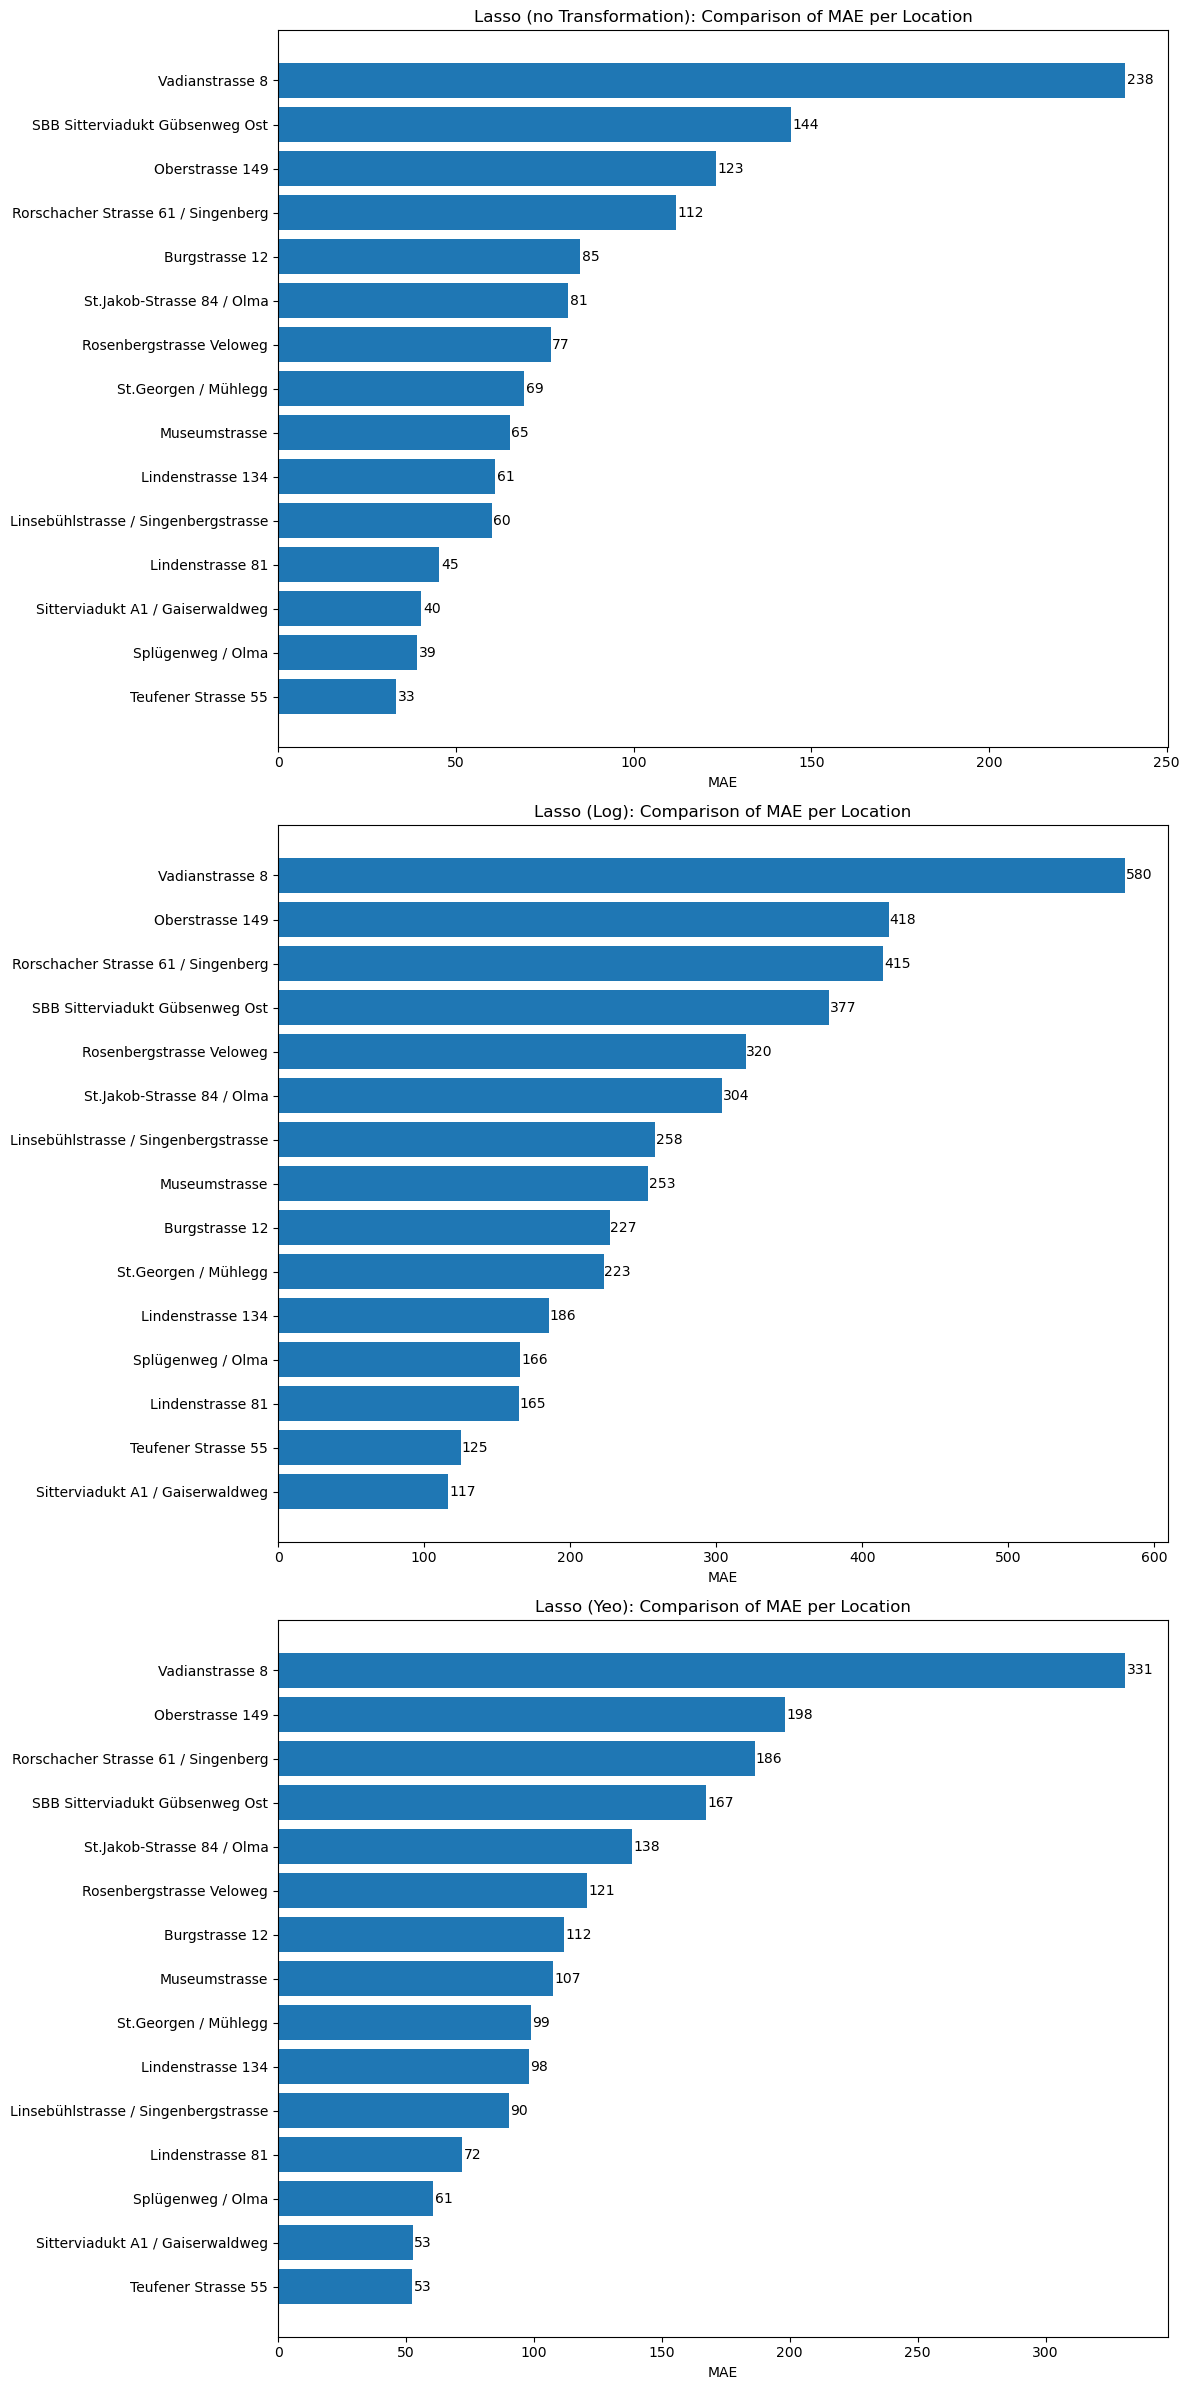

In [47]:
# Visualise MAE for the Lasso Regression Model with different (or none) Transformation technique for different locations.

fig, axs = plt.subplots(3, 1, figsize=(12, 24))  # 3 rows, 1 column

# Plot for Ridge (no transformation)
names = list(mae_scores_dict_lasso.keys())

# Sorting the locations by MAE
mae = [mae_scores_dict_lasso[ort] for ort in names]
sorted_pairs = sorted(zip(mae, names))
mae, names = zip(*sorted_pairs)
axs[0].barh(names, mae)

# Adding the number behind the bar
for bar in axs[0].containers[0]:
    width = bar.get_width()
    label_x_pos = width + 0.5
    axs[0].text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{width:.0f}", va="center")

# Setting a lable and titel
axs[0].set_xlabel("MAE")
axs[0].set_title("Lasso (no Transformation): Comparison of MAE per Location")

# Repeating the steps from above for the Lasso Model with a logarithmic transformation
names = list(mae_scores_dict_lasso_log.keys())
mae = [mae_scores_dict_lasso_log[ort] for ort in names]
sorted_pairs = sorted(zip(mae, names))
mae, names = zip(*sorted_pairs)
axs[1].barh(names, mae)
for bar in axs[1].containers[0]:
    width = bar.get_width()
    label_x_pos = width + 0.5
    axs[1].text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{width:.0f}", va="center")
axs[1].set_xlabel("MAE")
axs[1].set_title("Lasso (Log): Comparison of MAE per Location")


# Repeating the steps from above for the Lasso Model with a Yeo Johnson transformation
names = list(mae_scores_dict_lasso_yeo.keys())
mae = [mae_scores_dict_lasso_yeo[ort] for ort in names]
sorted_pairs = sorted(zip(mae, names))
mae, names = zip(*sorted_pairs)
axs[2].barh(names, mae)
for bar in axs[2].containers[0]:
    width = bar.get_width()
    label_x_pos = width + 0.5
    axs[2].text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{width:.0f}", va="center")
axs[2].set_xlabel("MAE")
axs[2].set_title("Lasso (Yeo): Comparison of MAE per Location")



plt.tight_layout()
plt.show()

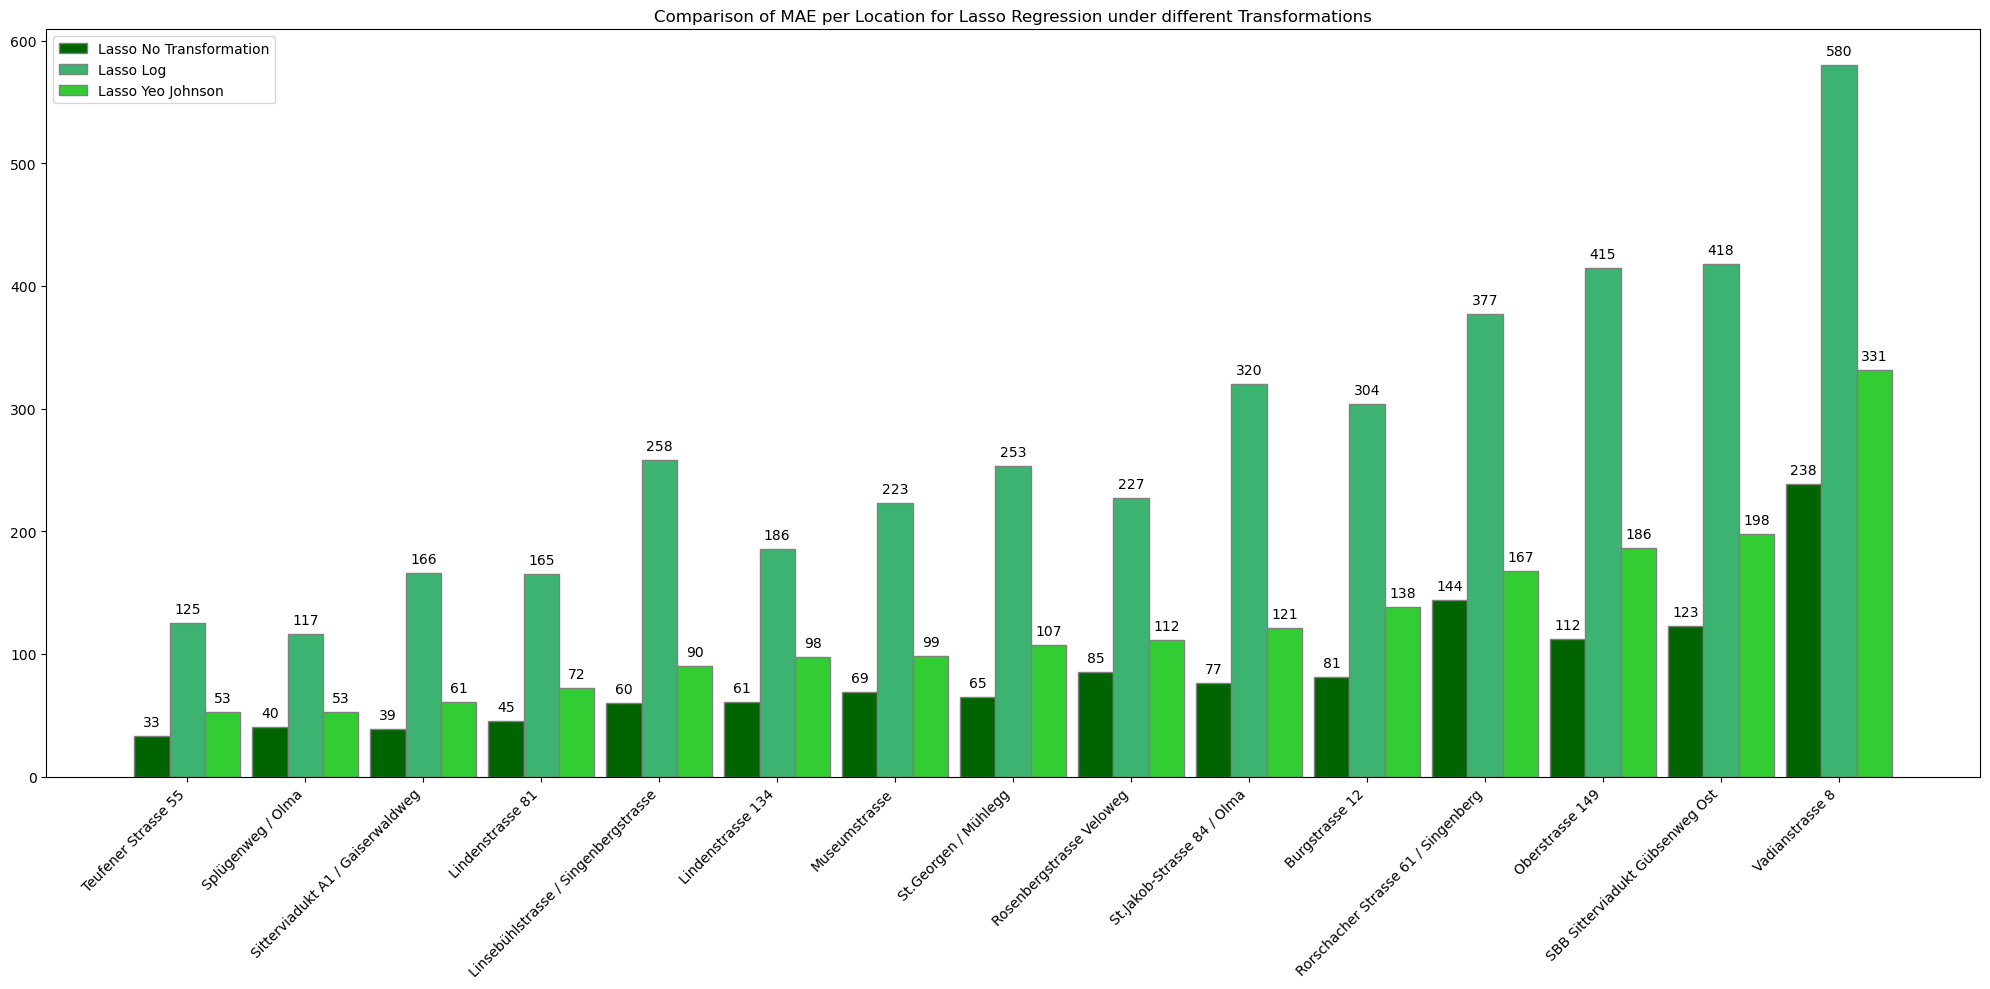

In [48]:
# Visualise MAE for the Lasso Regression Model with different (or none) Transformation technique for different locations in one plot

locations = list(mae_scores_dict_lasso.keys())
mae = [mae_scores_dict_lasso[ort] for ort in names]
mae_log = [mae_scores_dict_lasso_log[ort] for ort in names]
mae_yeo = [mae_scores_dict_lasso_yeo[ort] for ort in names]

# Number of locations
n_locations = len(locations)

barWidth = 0.3
r1 = np.arange(n_locations)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bars with new colors
plt.figure(figsize=(20, 10))
plt.bar(r1, mae, color="darkgreen", width=barWidth, edgecolor="grey", label="Lasso No Transformation")
plt.bar(r2, mae_log, color="mediumseagreen", width=barWidth, edgecolor="grey", label="Lasso Log")
plt.bar(r3, mae_yeo, color="limegreen", width=barWidth, edgecolor="grey", label="Lasso Yeo Johnson")


vertical_offset = max(max(mae), max(mae_log), max(mae_yeo)) * 0.01

# Function to add value labels on top of the bars
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = "bottom"
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.0f}".format(y_value)
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha="center",                
            va=va)                      


add_value_labels(plt.gca(), spacing=int(vertical_offset))

plt.xticks([r + barWidth for r in r1], locations, rotation=45, ha="right")

plt.legend()
plt.title("Comparison of MAE per Location for Lasso Regression under different Transformations")

plt.tight_layout()  
plt.show()

In [49]:
#Calculate the means and the Median of MAE and MSE

# Calculate mean and median for MAE (no transformation)
mae_values_normal = list(mae_scores_dict_lasso.values())
mae_mean_normal = np.mean(mae_values_normal)
mae_median_normal = np.median(mae_values_normal)

mse_values_normal = list(mse_scores_dict_lasso.values())
mse_mean_normal = np.mean(mse_values_normal)
mse_median_normal = np.median(mse_values_normal)

# Calculate mean and median for MAE (yeo-johnson transformation)
mae_values_yeo = list(mae_scores_dict_lasso_yeo.values())
mae_mean_yeo = np.mean(mae_values_yeo)
mae_median_yeo = np.median(mae_values_yeo)

mse_values_yeo = list(mse_scores_dict_lasso_yeo.values())
mse_mean_yeo = np.mean(mse_values_yeo)
mse_median_yeo = np.median(mse_values_yeo)


# Calculate mean and median for MAE (log transformation)
mae_values_log = list(mae_scores_dict_lasso_log.values())
mae_mean_log = np.mean(mae_values_log)
mae_median_log = np.median(mae_values_log)

mse_values_log = list(mse_scores_dict_lasso_log.values())
mse_mean_log = np.mean(mse_values_log)
mse_median_log = np.median(mse_values_log)

print("MAE Lasso (No Transformation):")
print(f"Mean: {mae_mean_normal}, Median: {mae_median_normal}")

print("MAE Lasso (Yeo-Johnson Transformation):")
print(f"Mean: {mae_mean_yeo}, Median: {mae_median_yeo}")

print("MAE Lasso(Log Transformation):")
print(f"Mean: {mae_mean_log}, Median: {mae_median_log}")

print("MSE Lasso (No Transformation):")
print(f"Mean: {mse_mean_normal}, Median: {mse_median_normal}")

print("MSE Lasso (Yeo-Johnson):")
print(f"Mean: {mse_mean_yeo}, Median: {mse_median_yeo}")

print("MSE Lasso (Log Transformation):")
print(f"Mean: {mse_mean_log}, Median: {mse_median_log}")


MAE Lasso (No Transformation):
Mean: 84.95461205245789, Median: 69.19183047434797
MAE Lasso (Yeo-Johnson Transformation):
Mean: 125.72825707688604, Median: 107.35541707805586
MAE Lasso(Log Transformation):
Mean: 275.58025915212306, Median: 253.18882137564387
MSE Lasso (No Transformation):
Mean: 17375.57614771242, Median: 9395.271392331215
MSE Lasso (Yeo-Johnson):
Mean: 34592.20654919169, Median: 17854.705704652988
MSE Lasso (Log Transformation):
Mean: 113517.1390112243, Median: 80410.15134359947


In [50]:
# Random Forest (without transformation as it handles non-linear relationships )
# Looping through locations and applying RandomForestRegressor

# Creating dictionaries to store the MAE and MSE values
mse_scores_dict_rf = {}
mae_scores_dict_rf = {}

# Looping over all the locations
for ort in names:
    df1 = df_dict[ort]
    X_2 = df1.drop(columns=["Anzahl Velos", "Datum", "Monat", "Jahr", "Bezeichnung"])
    y_2 = df1["Anzahl Velos"]
    tss = TimeSeriesSplit(n_splits=5) # Perform CV for Timeseries

    # creating lists to store the MSE and MAE values for every time series split
    mse_scores = []
    mae_scores = []

    for train_index, test_index in tss.split(X_2):
        X_train_2, X_test_2 = X_2.iloc[train_index, :], X_2.iloc[test_index, :]
        y_train_2, y_test_2 = y_2.iloc[train_index], y_2.iloc[test_index]

        rf = RandomForestRegressor(random_state=42)

        # Fit the model on the current split
        rf.fit(X_train_2, y_train_2)

        # Predicting for each split
        y_pred_2 = rf.predict(X_test_2)

        # Calculating and storing the MSE and MAE values
        mse = mean_squared_error(y_test_2, y_pred_2)
        mae = mean_absolute_error(y_test_2, y_pred_2)
        mse_scores.append(mse)
        mae_scores.append(mae)

    # Adding the MAE and MSE average to the dictionary for each location 
    mse_scores_dict_rf[ort] = np.mean(mse_scores)
    mae_scores_dict_rf[ort] = np.mean(mae_scores)


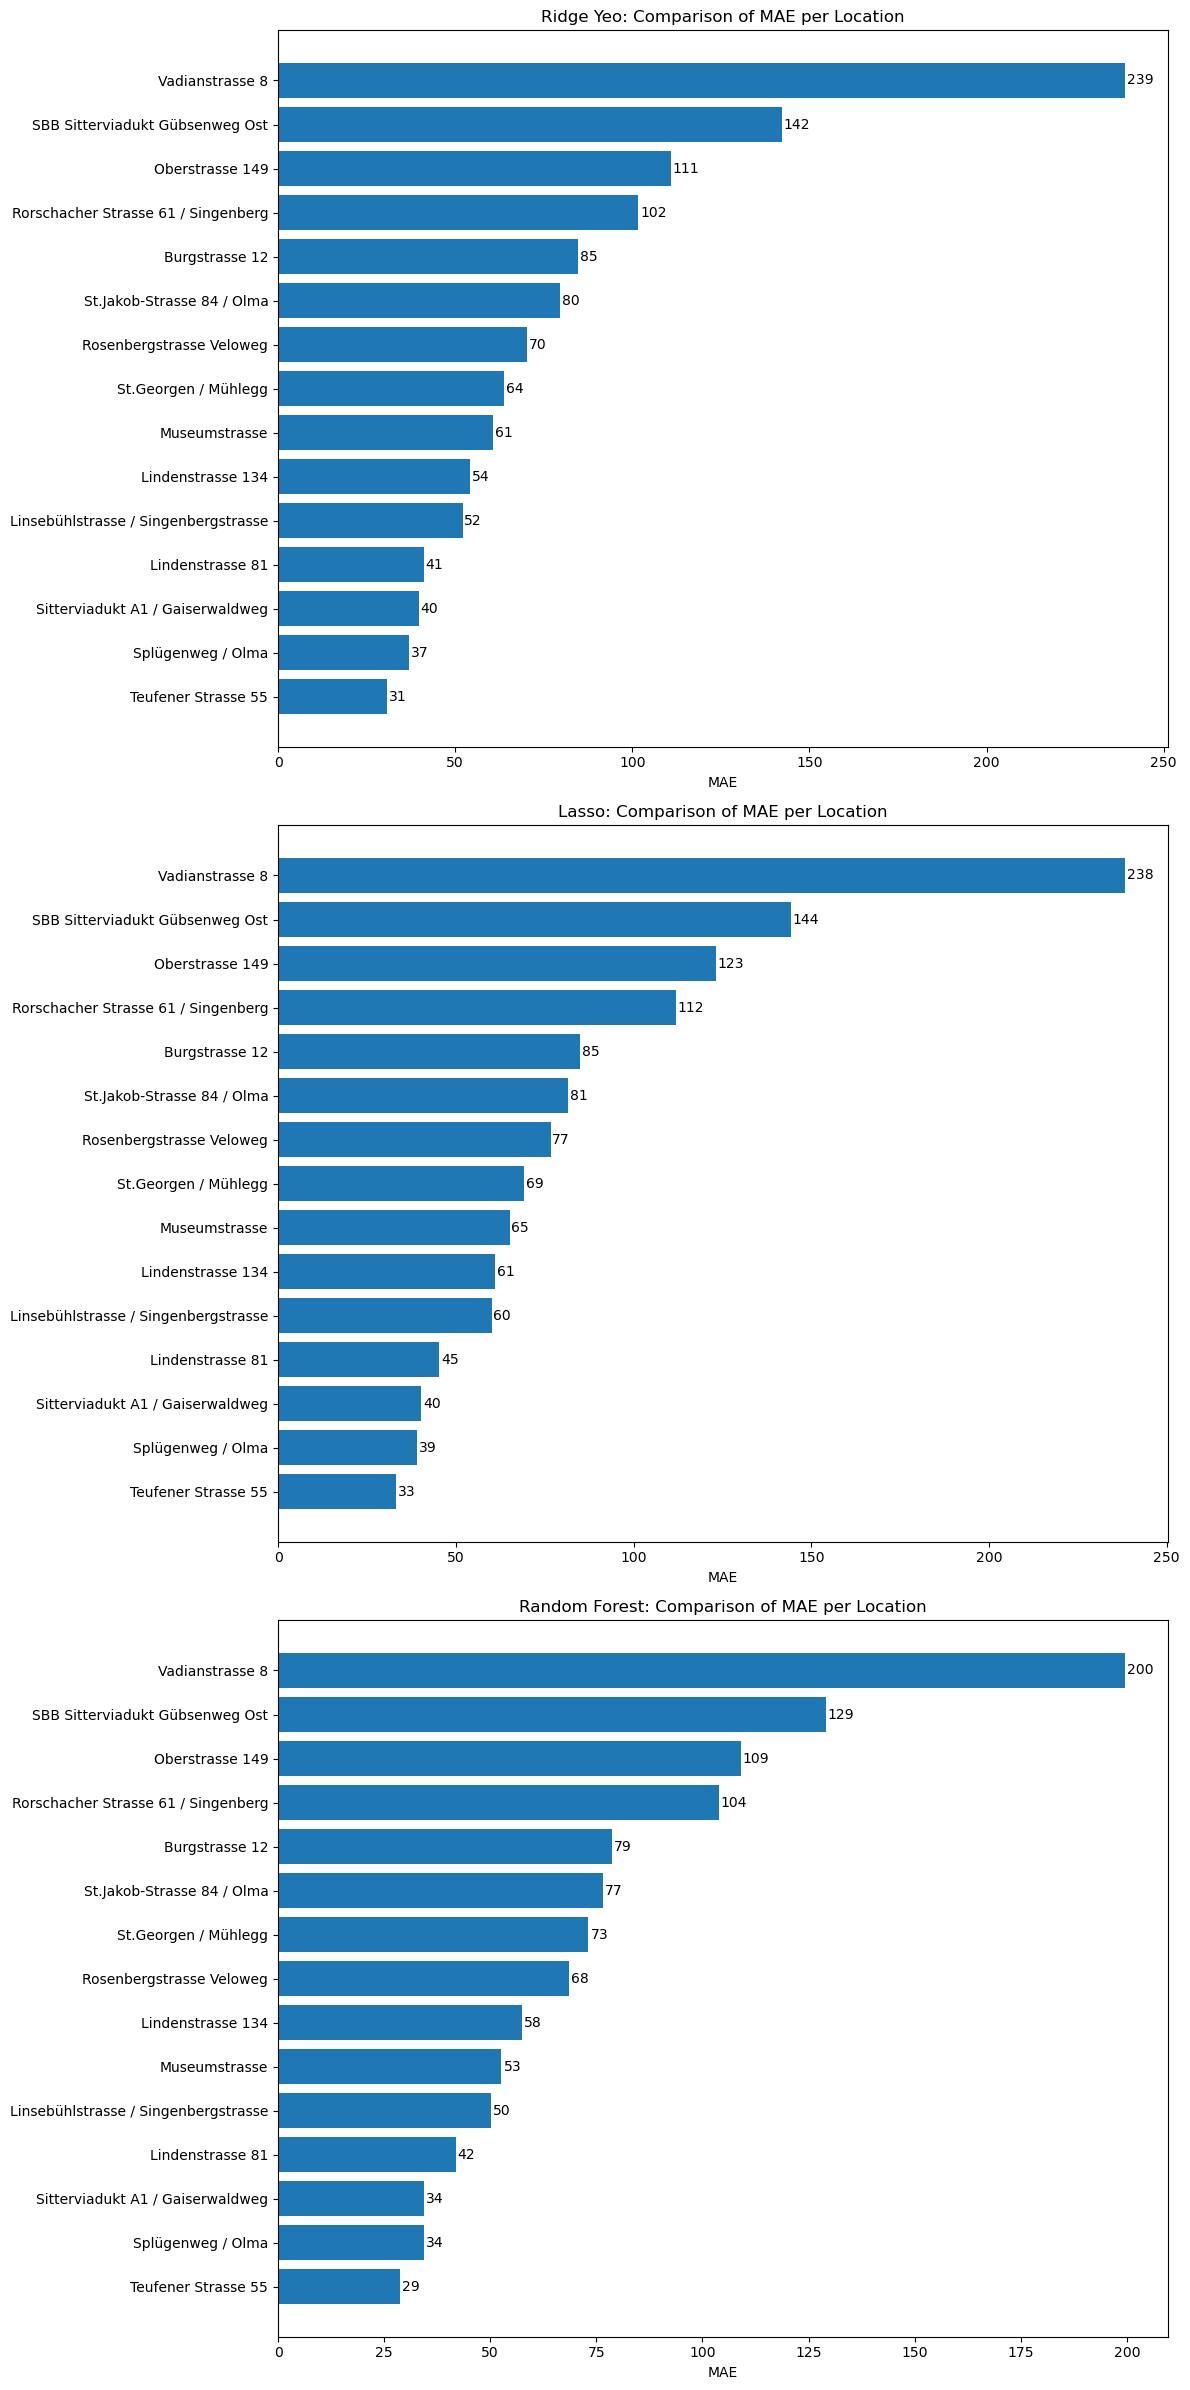

In [51]:
# Visualise MAE for the Lasso with no Transformation, for Ridge with Yeo Johnson and for Random Forest

fig, axs = plt.subplots(3, 1, figsize=(12, 24))  # 3 rows, 1 column

# Plot for Ridge with Yeo-Johnson transformation
names = list(mae_scores_dict_ridge_yeo.keys())

# Sorting the locations by MAE
mae = [mae_scores_dict_ridge_yeo[ort] for ort in names]
sorted_pairs = sorted(zip(mae, names))
mae, names = zip(*sorted_pairs)
axs[0].barh(names, mae)

# Adding the number behind the bar
for bar in axs[0].containers[0]:
    width = bar.get_width()
    label_x_pos = width + 0.5
    axs[0].text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{width:.0f}", va="center")

# Setting the title and label
axs[0].set_xlabel("MAE")
axs[0].set_title("Ridge Yeo: Comparison of MAE per Location")

# Repeating the steps from above for the Lasso model without transformation
names = list(mae_scores_dict_lasso.keys())
mae = [mae_scores_dict_lasso[ort] for ort in names]
sorted_pairs = sorted(zip(mae, names))
mae, names = zip(*sorted_pairs)
axs[1].barh(names, mae)
for bar in axs[1].containers[0]:
    width = bar.get_width()
    label_x_pos = width + 0.5
    axs[1].text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{width:.0f}", va="center")
axs[1].set_xlabel("MAE")
axs[1].set_title("Lasso: Comparison of MAE per Location")

# Repeating the steps from above for the random forest
names = list(mae_scores_dict_rf.keys())
mae = [mae_scores_dict_rf[ort] for ort in names]
sorted_pairs = sorted(zip(mae, names))
mae, names = zip(*sorted_pairs)
axs[2].barh(names, mae)
for bar in axs[2].containers[0]:
    width = bar.get_width()
    label_x_pos = width + 0.5
    axs[2].text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{width:.0f}", va="center")
axs[2].set_xlabel("MAE")
axs[2].set_title("Random Forest: Comparison of MAE per Location")

plt.tight_layout()


plt.show()

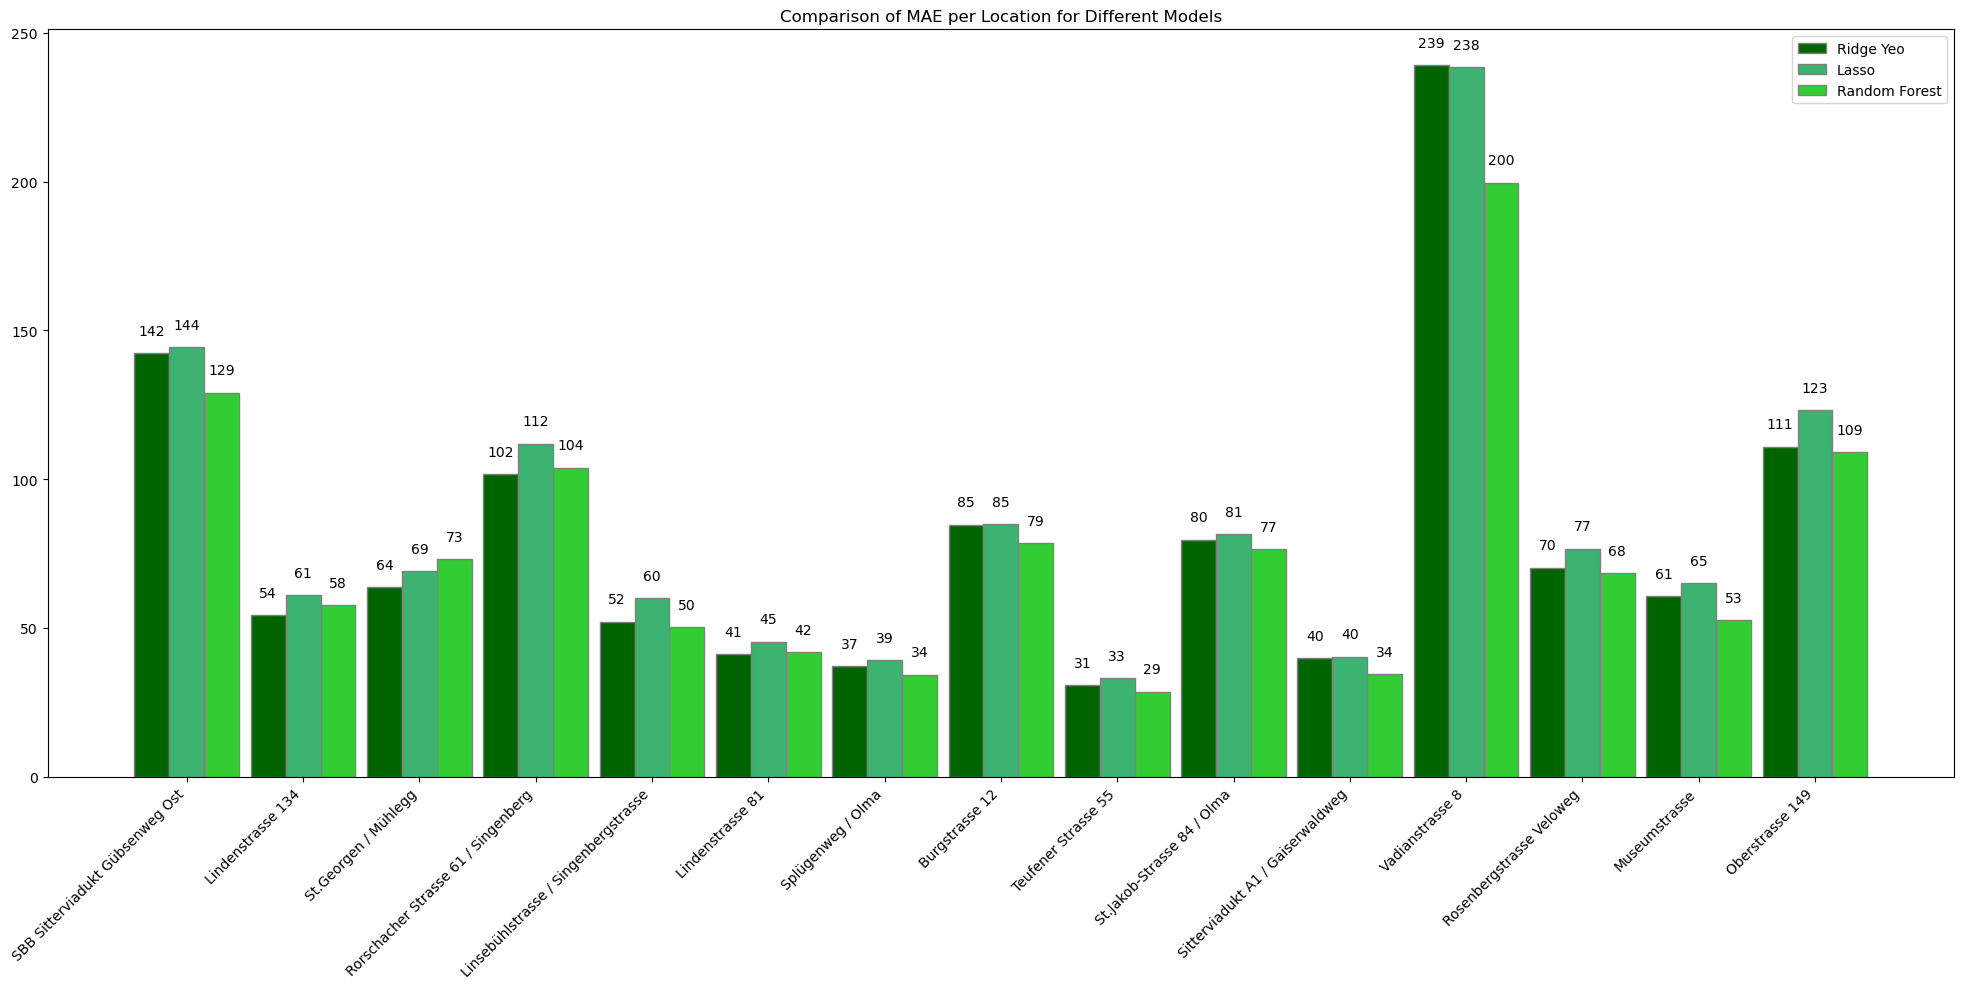

In [52]:
# Visualise MAE for the Lasso with no Transformation, for Ridge with Yeo Johnson and for Random Forest in one plot

locations = list(mae_scores_dict_ridge_yeo.keys())
mae_ridge = [mae_scores_dict_ridge_yeo[loc] for loc in locations]
mae_lasso = [mae_scores_dict_lasso[loc] for loc in locations]
mae_rf = [mae_scores_dict_rf[loc] for loc in locations]

# Number of locations
n_locations = len(locations)

barWidth = 0.3
r1 = np.arange(n_locations)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bars with new colors
plt.figure(figsize=(20, 10))
plt.bar(r1, mae_ridge, color="darkgreen", width=barWidth, edgecolor="grey", label="Ridge Yeo")
plt.bar(r2, mae_lasso, color="mediumseagreen", width=barWidth, edgecolor="grey", label="Lasso")
plt.bar(r3, mae_rf, color="limegreen", width=barWidth, edgecolor="grey", label="Random Forest")


vertical_offset = max(max(mae_ridge), max(mae_lasso), max(mae_rf)) * 0.05  

# Function to add value labels on top of the bars
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = "bottom"
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.0f}".format(y_value)
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha="center",                
            va=va)                      


add_value_labels(plt.gca(), spacing=int(vertical_offset))

plt.xticks([r + barWidth for r in r1], locations, rotation=45, ha="right")

plt.legend()
plt.title("Comparison of MAE per Location for Different Models")

plt.tight_layout()  
plt.show()

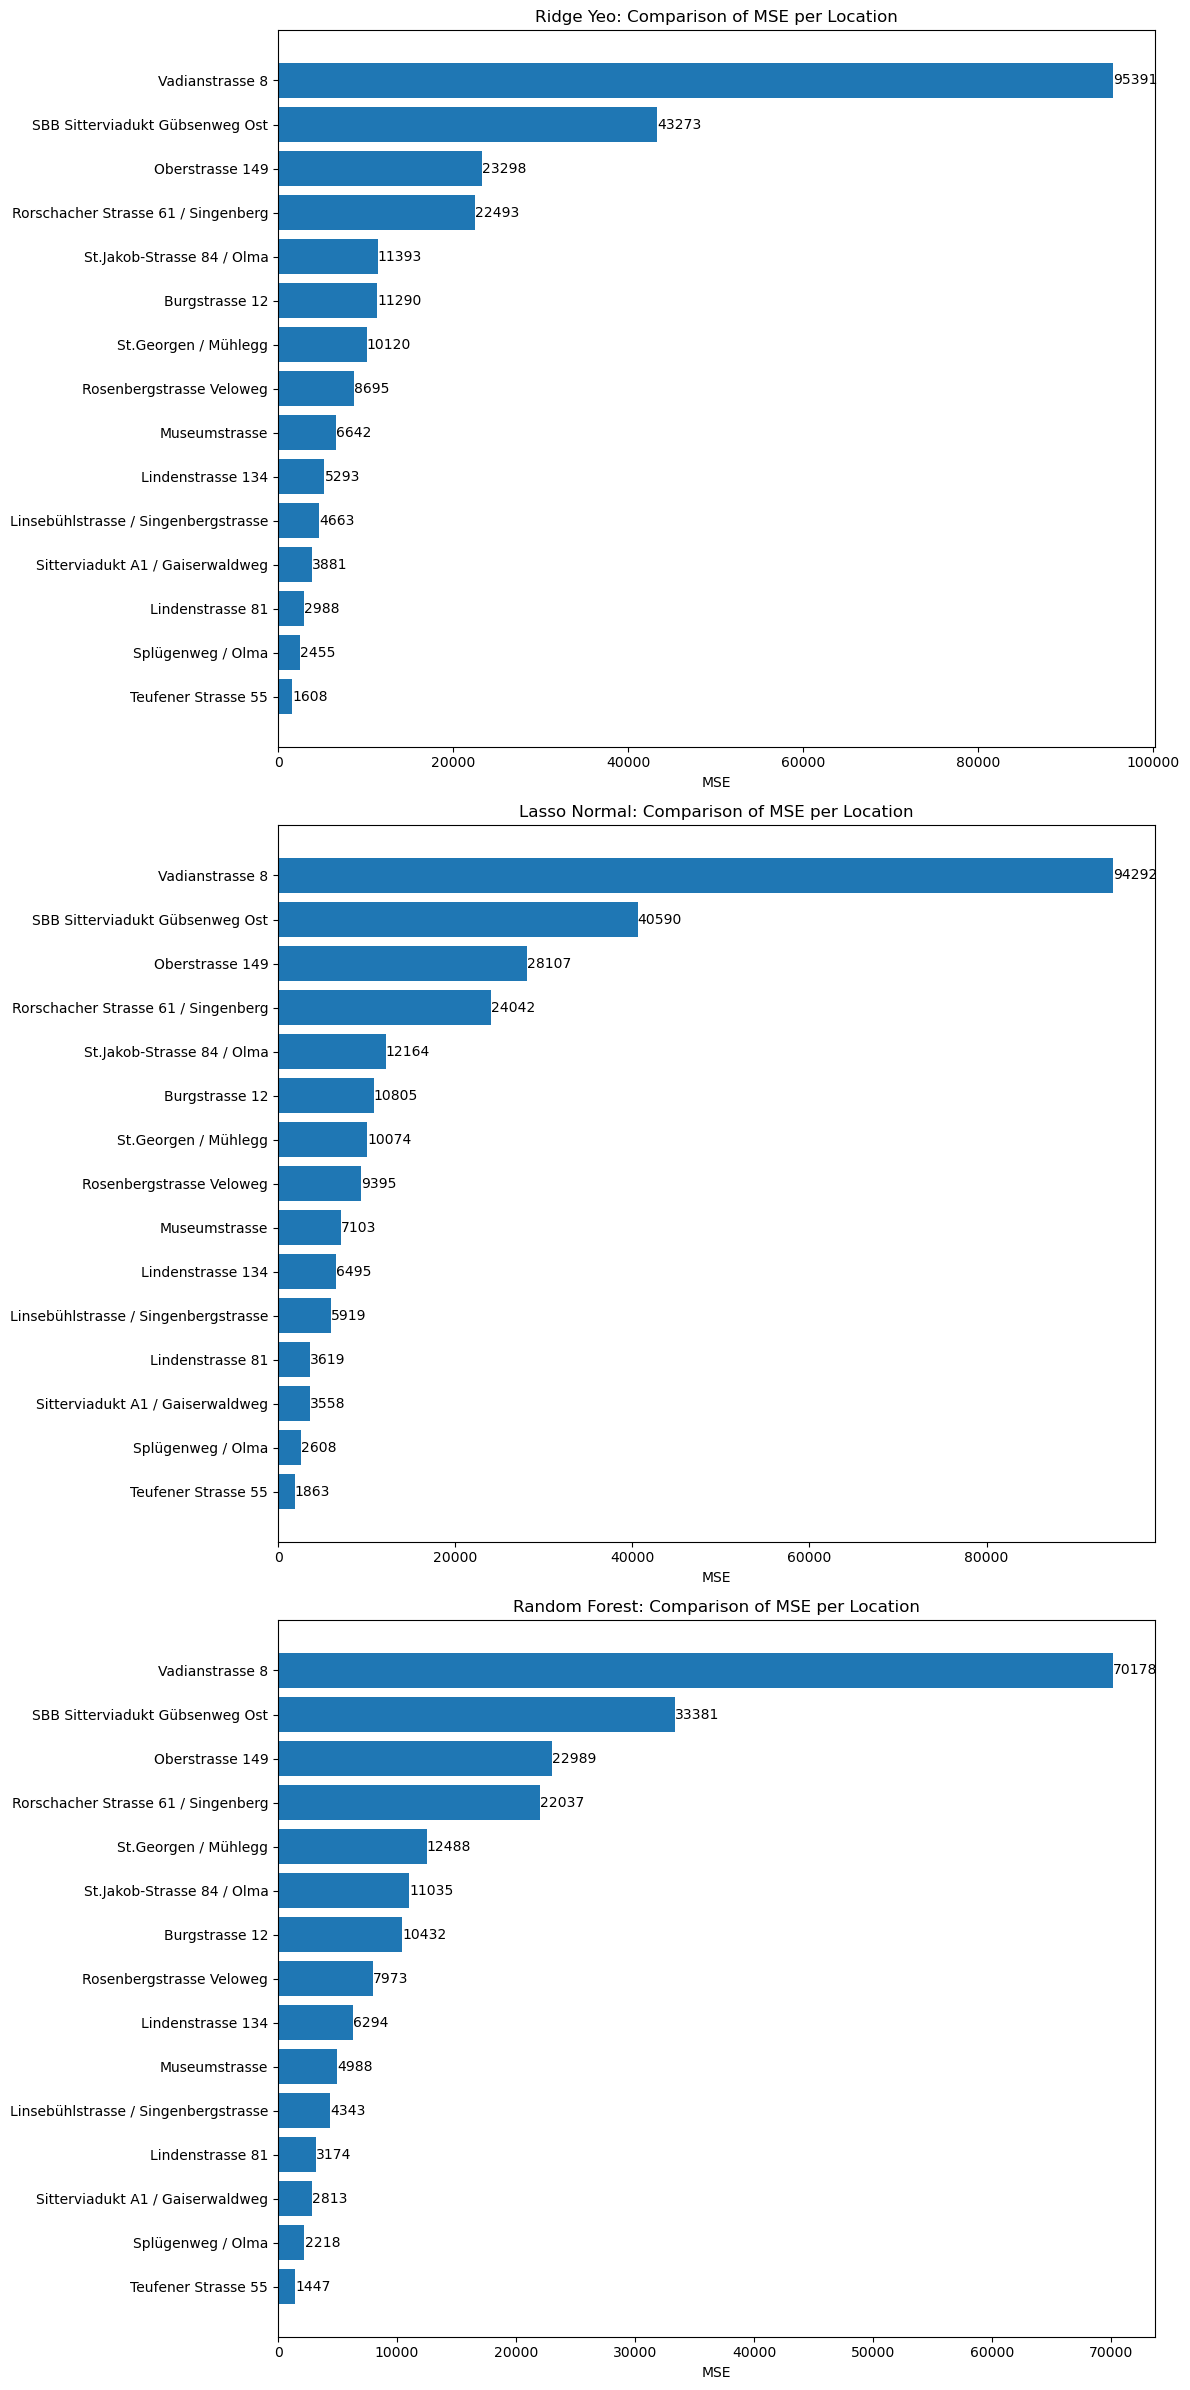

In [53]:
#Visualise MSE for the Lasso with no Transformation, for Ridge with Yeo Johnson and for Random Forest

fig, axs = plt.subplots(3, 1, figsize=(12, 24))  # 3 rows, 1 column

# Plotting the MSE for the Ridge Model with a Yeo-Johnson transformation
names = list(mse_scores_dict_ridge_yeo.keys())

# Sorting the locations by MSE
mse = [mse_scores_dict_ridge_yeo[ort] for ort in names]
sorted_pairs = sorted(zip(mse, names))
mse, names = zip(*sorted_pairs)
axs[0].barh(names, mse)

# Adding the number behind the bar
for bar in axs[0].containers[0]:
    width = bar.get_width()
    label_x_pos = width + 5
    axs[0].text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{width:.0f}", va="center")

# Setting title and label
axs[0].set_xlabel("MSE")
axs[0].set_title("Ridge Yeo: Comparison of MSE per Location")

# Repeating the steps from above for the Lasso Model without transformation
names = list(mse_scores_dict_lasso.keys())
mse = [mse_scores_dict_lasso[ort] for ort in names]
sorted_pairs = sorted(zip(mse, names))
mse, names = zip(*sorted_pairs)
axs[1].barh(names, mse)
for bar in axs[1].containers[0]:
    width = bar.get_width()
    label_x_pos = width + 5
    axs[1].text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{width:.0f}", va="center")
axs[1].set_xlabel("MSE")
axs[1].set_title("Lasso Normal: Comparison of MSE per Location")

# Repeating the steps from above for the random forest
names = list(mse_scores_dict_rf.keys())
mse = [mse_scores_dict_rf[ort] for ort in names]
sorted_pairs = sorted(zip(mse, names))
mse, names = zip(*sorted_pairs)
axs[2].barh(names, mse)
for bar in axs[2].containers[0]:
    width = bar.get_width()
    label_x_pos = width + 5
    axs[2].text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{width:.0f}", va="center")
axs[2].set_xlabel("MSE")
axs[2].set_title("Random Forest: Comparison of MSE per Location")

plt.tight_layout()
#plt.savefig("Project/MSE_final_3.png", bbox_inches="tight") 

plt.show()

For almost every location (perhaps 1 or 2 exceptions) the MAE and MSE values are the lowest for the random forest model. Therefore, that is our final model and could now be used to predict the number of cyclists at these 15 locations in the city of St. Gallen